# Compare vaccination strategies per ERVA and age groups

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import datetime
from experiments import get_experiments_results
from env_var import EPIDEMIC, MAPPINGS, EXPERIMENTS
from matplotlib.lines import Line2D

mpl.rcParams['figure.dpi']= 175
plt.style.use('ggplot')

In [2]:
# Simulation parameters
num_age_groups = EXPERIMENTS['num_age_groups']
num_ervas = EXPERIMENTS['num_ervas']
T = EXPERIMENTS['simulate_T']
init_vacc = EXPERIMENTS['init_vacc']
u = EXPERIMENTS['vaccines_per_day']
r_experiments = EXPERIMENTS['r_effs']
t0 = EXPERIMENTS['t0']

# Plot parameters
plot_interval = 15
ervas_labels = EPIDEMIC['ervas_order']
age_labels = MAPPINGS['age_groups'][num_age_groups]['names']
len_bar = 5
color_palette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sep_bet_group = 3*len_bar
# 57 is 2021-06-15
# T-30 is 2021-07-13
# T is 2021-08-11
t2 = T
t1 = T-30
legend_width = 3

strategies = [
    ('equal', EPIDEMIC['ws_vacc'], 'Pop only'),
    ('no_vacc', EPIDEMIC['ws_vacc'], 'No vaccination'),
    ('thl', EPIDEMIC['ws_vacc'], 'Pop, Inf and Hosp'),
    ('thl', [1/2, 1/2, 0], 'Pop and Hosp'),
    ('thl', [1/2, 0, 1/2], 'Pop and Inf'),
    ('thl', [0, 1/2, 1/2], 'Hosp and Inf'),
    ('thl', [0, 1, 0], 'Hosp only'),
    ('thl', [0, 0, 1], 'Inf only'),
]

In [3]:
all_results = get_experiments_results(num_age_groups=num_age_groups,
                                      num_ervas=num_ervas,
                                      init_vacc=True,
                                      strategies=strategies,
                                      u=u,
                                      T=T,
                                      r_experiments=r_experiments,
                                      t0=t0)

Finished R: 1.0. 1/4. Policy: Pop only. 1/8
Finished R: 1.0. 1/4. Policy: No vaccination. 2/8
Finished R: 1.0. 1/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.0. 1/4. Policy: Pop and Hosp. 4/8
Finished R: 1.0. 1/4. Policy: Pop and Inf. 5/8
Finished R: 1.0. 1/4. Policy: Hosp and Inf. 6/8
Finished R: 1.0. 1/4. Policy: Hosp only. 7/8
Finished R: 1.0. 1/4. Policy: Inf only. 8/8
Finished R: 1.25. 2/4. Policy: Pop only. 1/8
Finished R: 1.25. 2/4. Policy: No vaccination. 2/8
Finished R: 1.25. 2/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.25. 2/4. Policy: Pop and Hosp. 4/8
Finished R: 1.25. 2/4. Policy: Pop and Inf. 5/8
Finished R: 1.25. 2/4. Policy: Hosp and Inf. 6/8
Finished R: 1.25. 2/4. Policy: Hosp only. 7/8
Finished R: 1.25. 2/4. Policy: Inf only. 8/8
Finished R: 1.5. 3/4. Policy: Pop only. 1/8
Finished R: 1.5. 3/4. Policy: No vaccination. 2/8
Finished R: 1.5. 3/4. Policy: Pop, Inf and Hosp. 3/8
Finished R: 1.5. 3/4. Policy: Pop and Hosp. 4/8
Finished R: 1.5. 3/4. Policy: Pop and I

In [4]:
def plot_ervas(ax, r, metric, all_results, ervas_labels, t2=t2, t1=t1):
    results_for_r = all_results[r]
    
    total_strategies = len(results_for_r)
    space_erva = len_bar*(total_strategies-1) + sep_bet_group
    
    no_vacc_results = None
    for label, results_all_metrics in results_for_r:
        if label == 'No vaccination':
            no_vacc_results = results_all_metrics[metric]
            no_vacc_results = no_vacc_results.sum(axis=0)
            no_vacc_results = no_vacc_results[:, t1:t2]
    
    assert no_vacc_results is not None
    assert no_vacc_results.shape[0] == len(ervas_labels)
    
    total_plot_space = space_erva*len(ervas_labels) + sep_bet_group
    ax.set_xlim(0, total_plot_space)
    
    num_strategy = 0
    legend_elements = []
    for label, results_all_metrics in results_for_r:
        if label != 'No vaccination':
            policy_results = results_all_metrics[metric]
            policy_results = policy_results.sum(axis=0)
            policy_results = policy_results[:, t1:t2]

            assert policy_results.shape == no_vacc_results.shape
            relative_to_no_vacc = (no_vacc_results - policy_results)/no_vacc_results
            
            min_red_all_ervas = relative_to_no_vacc.min(axis=1)*100
            max_red_all_ervas = relative_to_no_vacc.max(axis=1)*100
            
            
            for erva_i in range(len(ervas_labels)):
                x1_square = erva_i*space_erva + sep_bet_group + num_strategy*len_bar
                y1_square = min_red_all_ervas[erva_i]
                y2_square = max_red_all_ervas[erva_i] - min_red_all_ervas[erva_i]

                ax.broken_barh([(x1_square, len_bar), ], (y1_square, y2_square),
                               color=color_palette[num_strategy])
                
            legend_elements.append(Line2D([0], [0], color=color_palette[num_strategy], lw=legend_width, label=label))
            
            num_strategy += 1
    
    space_bars = space_erva - sep_bet_group
    middle_of_space = space_bars/2
    pos_tick =  sep_bet_group + middle_of_space
    ticks = []
    for erva_i in range(len(ervas_labels)):
        abs_pos_tick = erva_i*space_erva + pos_tick
        ticks.append(abs_pos_tick)
        
    assert len(ticks) == len(ervas_labels)
    assert len(legend_elements) == total_strategies-1
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(ervas_labels)
    ax.set_yticks(np.arange(0, 105, 5))
    ax.legend(handles=legend_elements, loc='lower left')
    ax.set_xlabel('ERVA')
    ax.set_ylabel('Reduction in percentage')
    ax.set_title('Reduction in %s at ERVAs per policy . R=%s' % (metric, r))
    

    return ax

In [5]:
def plot_age_groups(ax, r, metric, all_results, age_labels, t2=t2, t1=t1):
    results_for_r = all_results[r]
    
    total_strategies = len(results_for_r)
    space_age_group = len_bar*(total_strategies-1) + sep_bet_group
    
    no_vacc_results = None
    for label, results_all_metrics in results_for_r:
        if label == 'No vaccination':
            no_vacc_results = results_all_metrics[metric]
            no_vacc_results = no_vacc_results.sum(axis=1)
            no_vacc_results = no_vacc_results[:, t1:t2]
    
    assert no_vacc_results is not None
    assert no_vacc_results.shape[0] == len(age_labels)
    
    total_plot_space = space_age_group*len(age_labels) + sep_bet_group
    ax.set_xlim(0, total_plot_space)
    
    num_strategy = 0
    legend_elements = []
    for label, results_all_metrics in results_for_r:
        if label != 'No vaccination':
            policy_results = results_all_metrics[metric]
            policy_results = policy_results.sum(axis=1)
            policy_results = policy_results[:, t1:t2]

            assert policy_results.shape == no_vacc_results.shape
            
#             zero_metric_no_vacc = no_vacc_results == 0
#             zero_metric_policy = policy_results == 0
#             assert np.all(zero_metric_policy, zero_metric_no_vacc)

            relative_to_no_vacc = (no_vacc_results - policy_results)/no_vacc_results
            
            min_red_all_ages = relative_to_no_vacc.min(axis=1)*100
            max_red_all_ages = relative_to_no_vacc.max(axis=1)*100
            
            
            for age_i in range(len(age_labels)):
                x1_square = age_i*space_age_group + sep_bet_group + num_strategy*len_bar
                y1_square = min_red_all_ages[age_i]
                y2_square = max_red_all_ages[age_i] - min_red_all_ages[age_i]

                ax.broken_barh([(x1_square, len_bar), ], (y1_square, y2_square),
                               color=color_palette[num_strategy])
                
            legend_elements.append(Line2D([0], [0], color=color_palette[num_strategy], lw=legend_width, label=label))
            
            num_strategy += 1
    
    space_bars = space_age_group - sep_bet_group
    middle_of_space = space_bars/2
    pos_tick =  sep_bet_group + middle_of_space
    ticks = []
    for age_i in range(len(age_labels)):
        abs_pos_tick = age_i*space_age_group + pos_tick
        ticks.append(abs_pos_tick)
        
    assert len(ticks) == len(age_labels)
    assert len(legend_elements) == total_strategies-1
    
    ax.set_xticks(ticks)
    ax.set_xticklabels(age_labels)
    ax.set_yticks(np.arange(0, 105, 5))
    ax.legend(handles=legend_elements, loc='lower left')
    ax.set_xlabel('Age group')
    ax.set_ylabel('Reduction in percentage')
    ax.set_title('Reduction in %s at age groups per policy . R=%s' % (metric, r))
    

    return ax

# Deaths at ERVAs

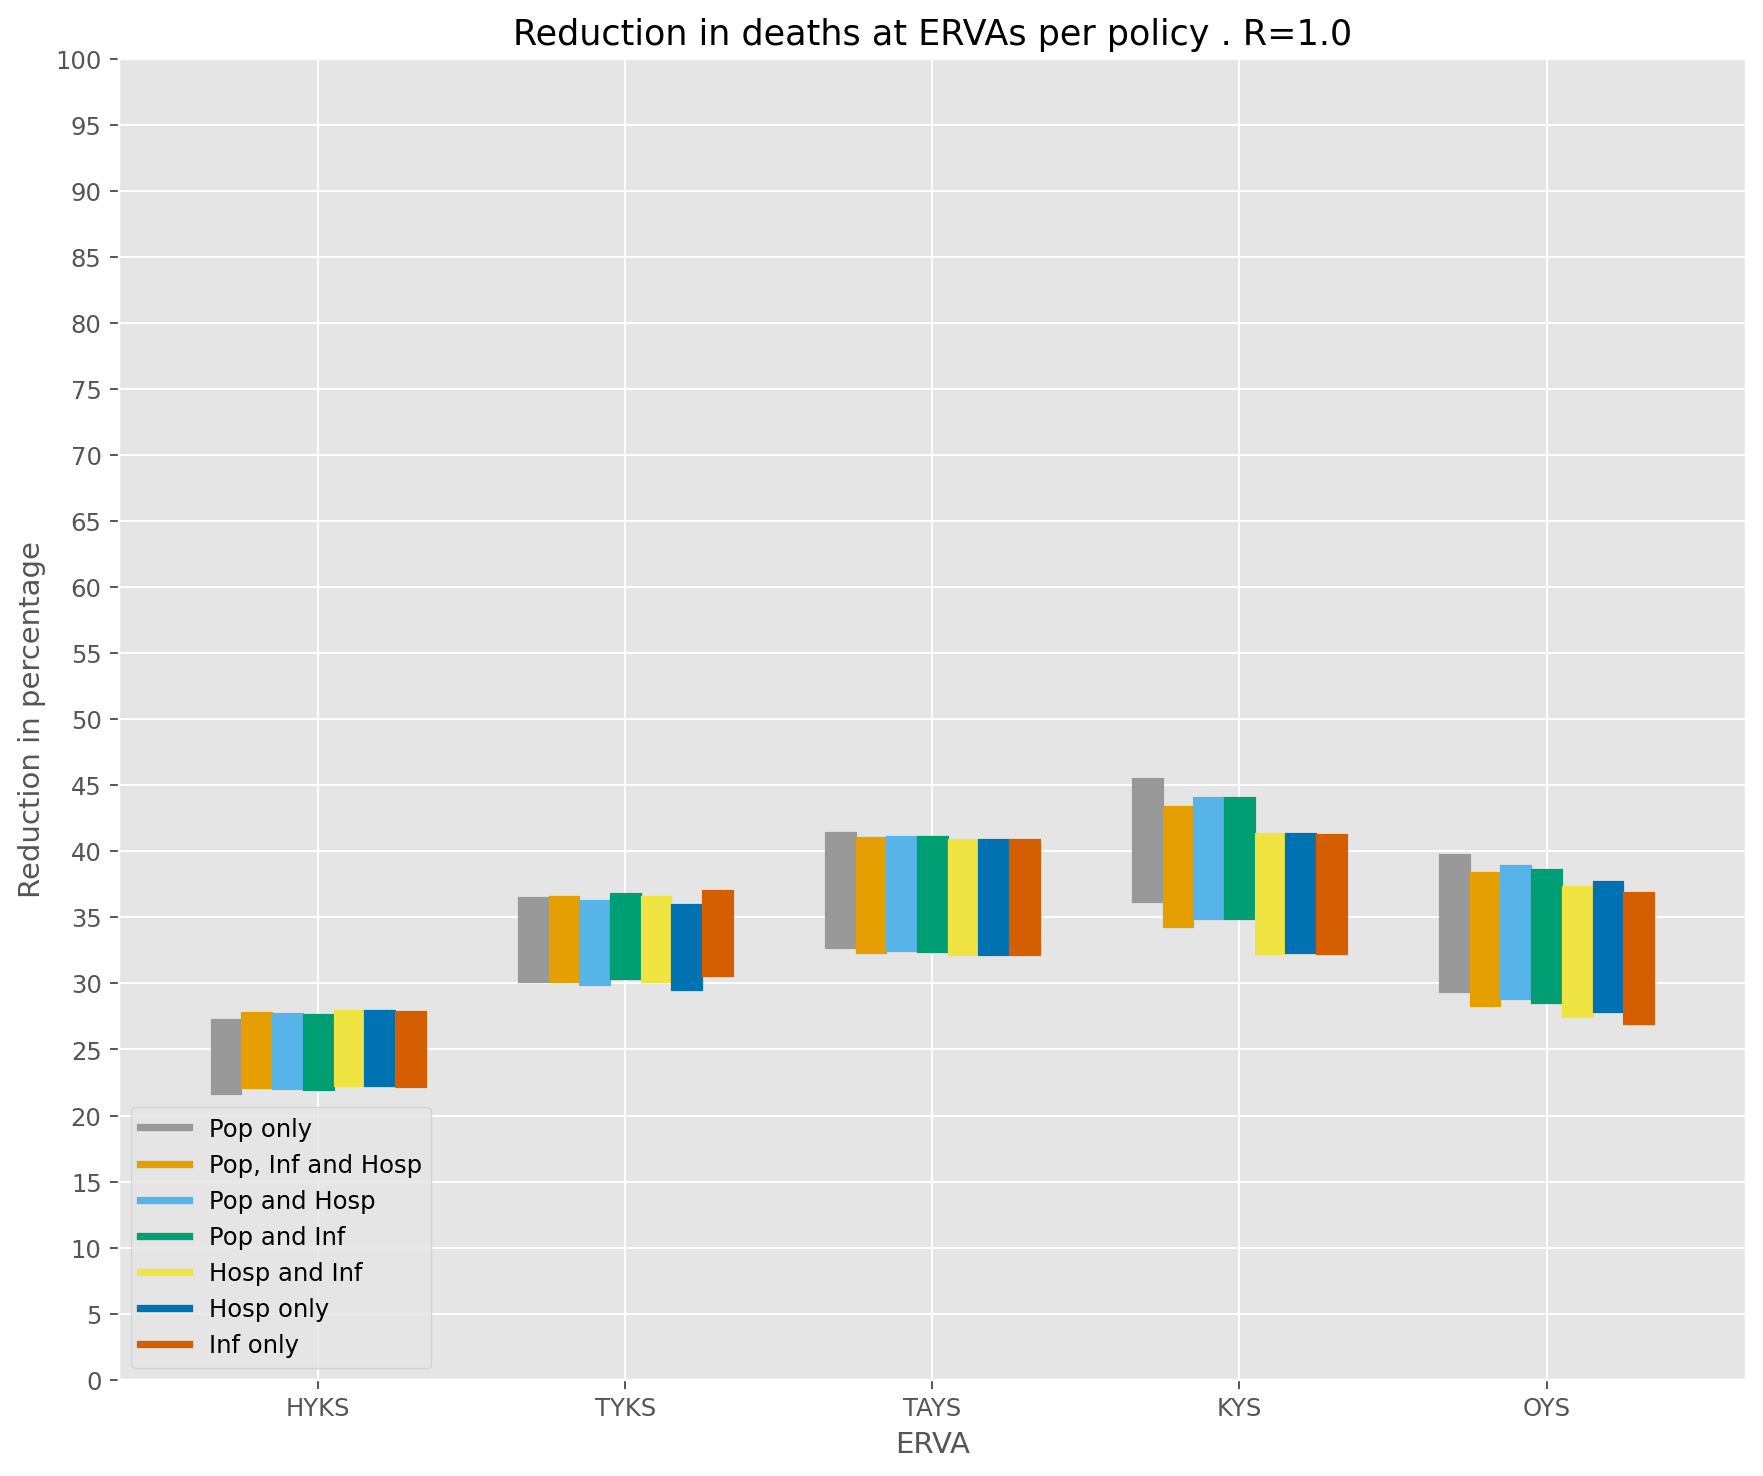

In [6]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[0], 'deaths', all_results, ervas_labels)

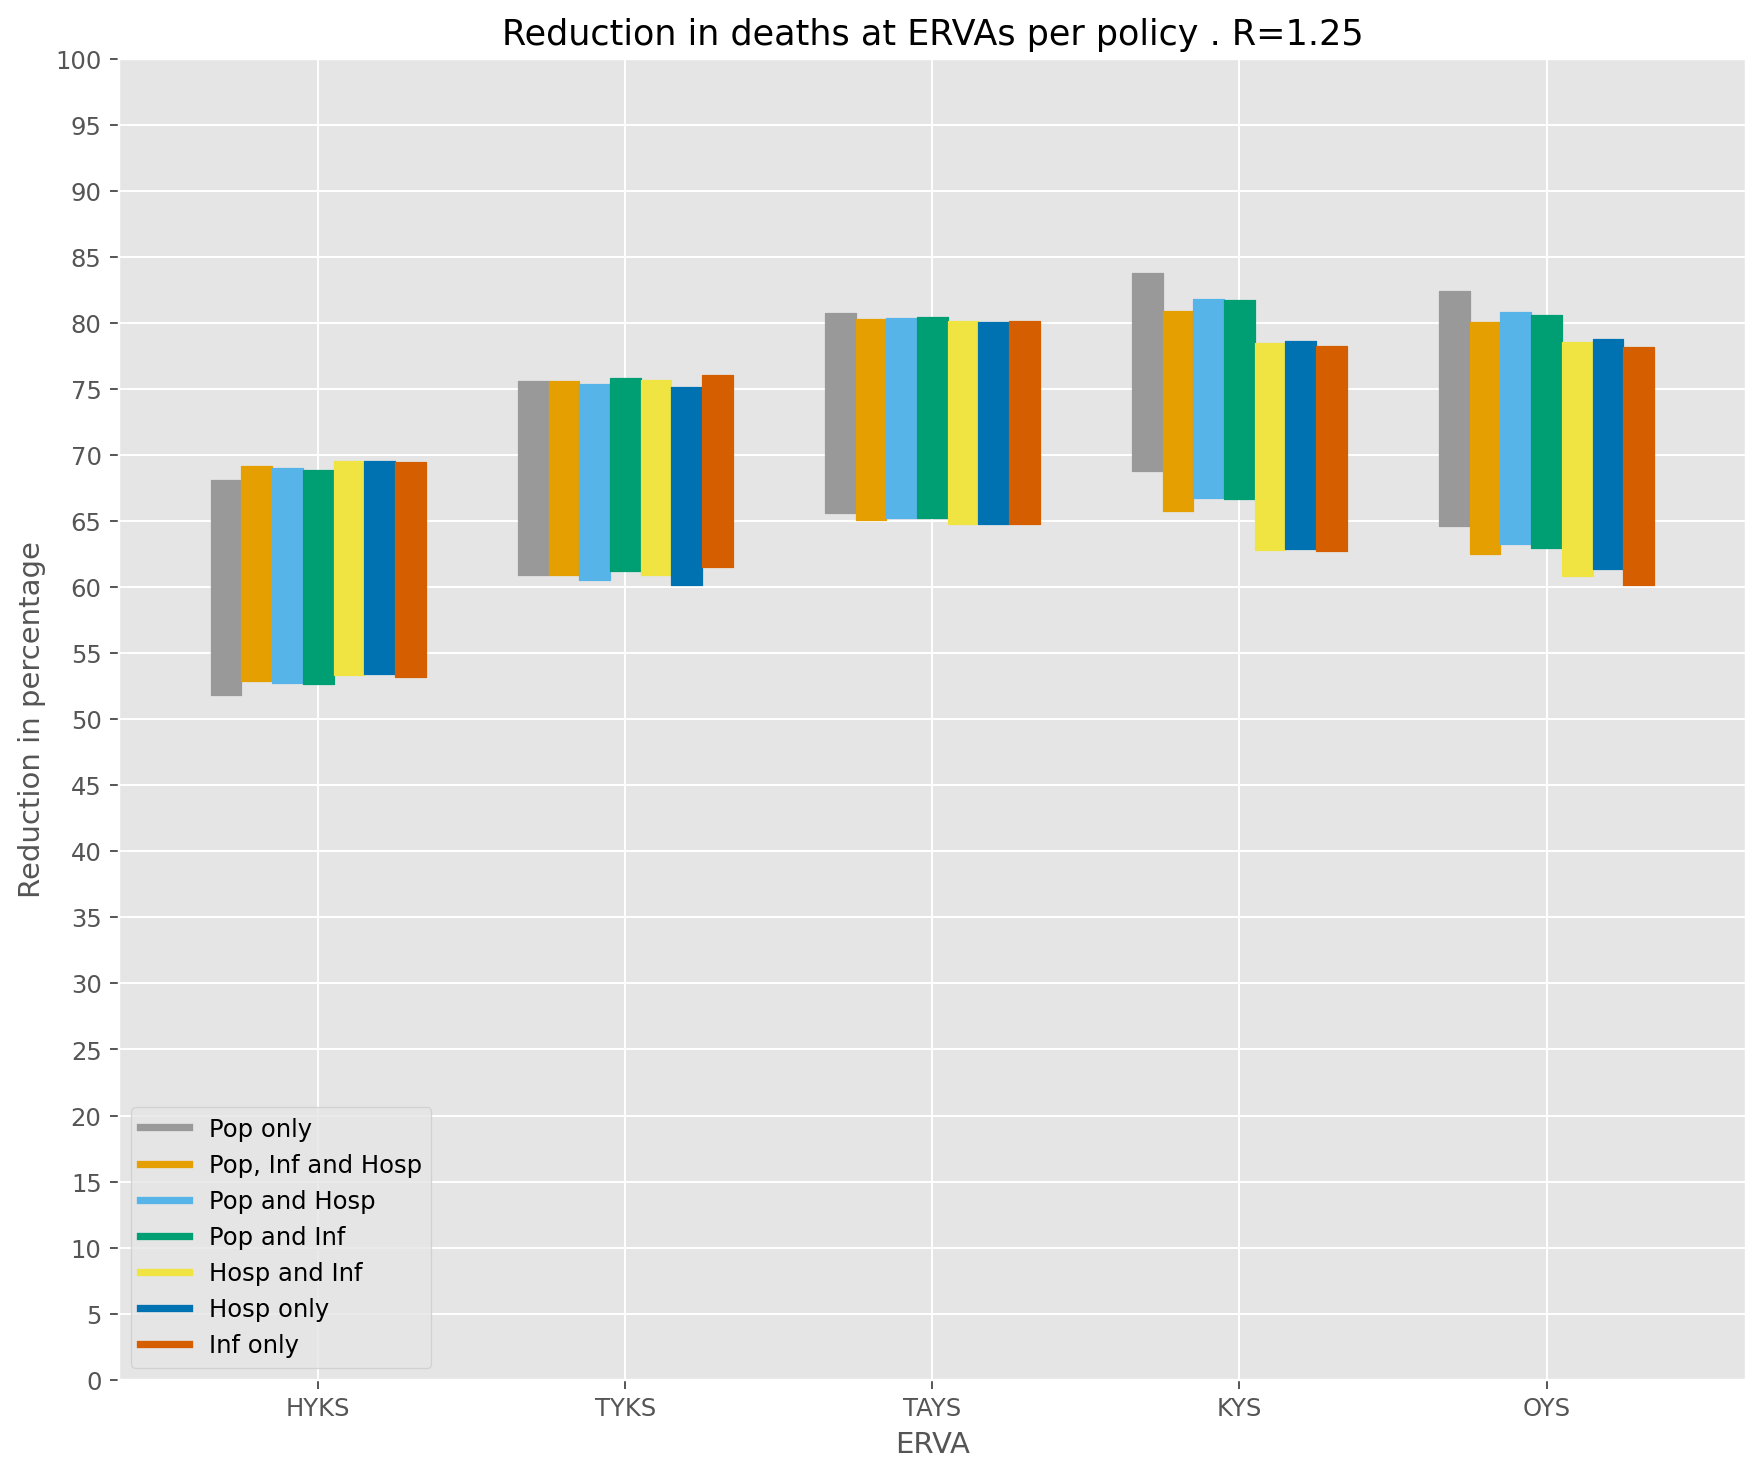

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[1], 'deaths', all_results, ervas_labels)

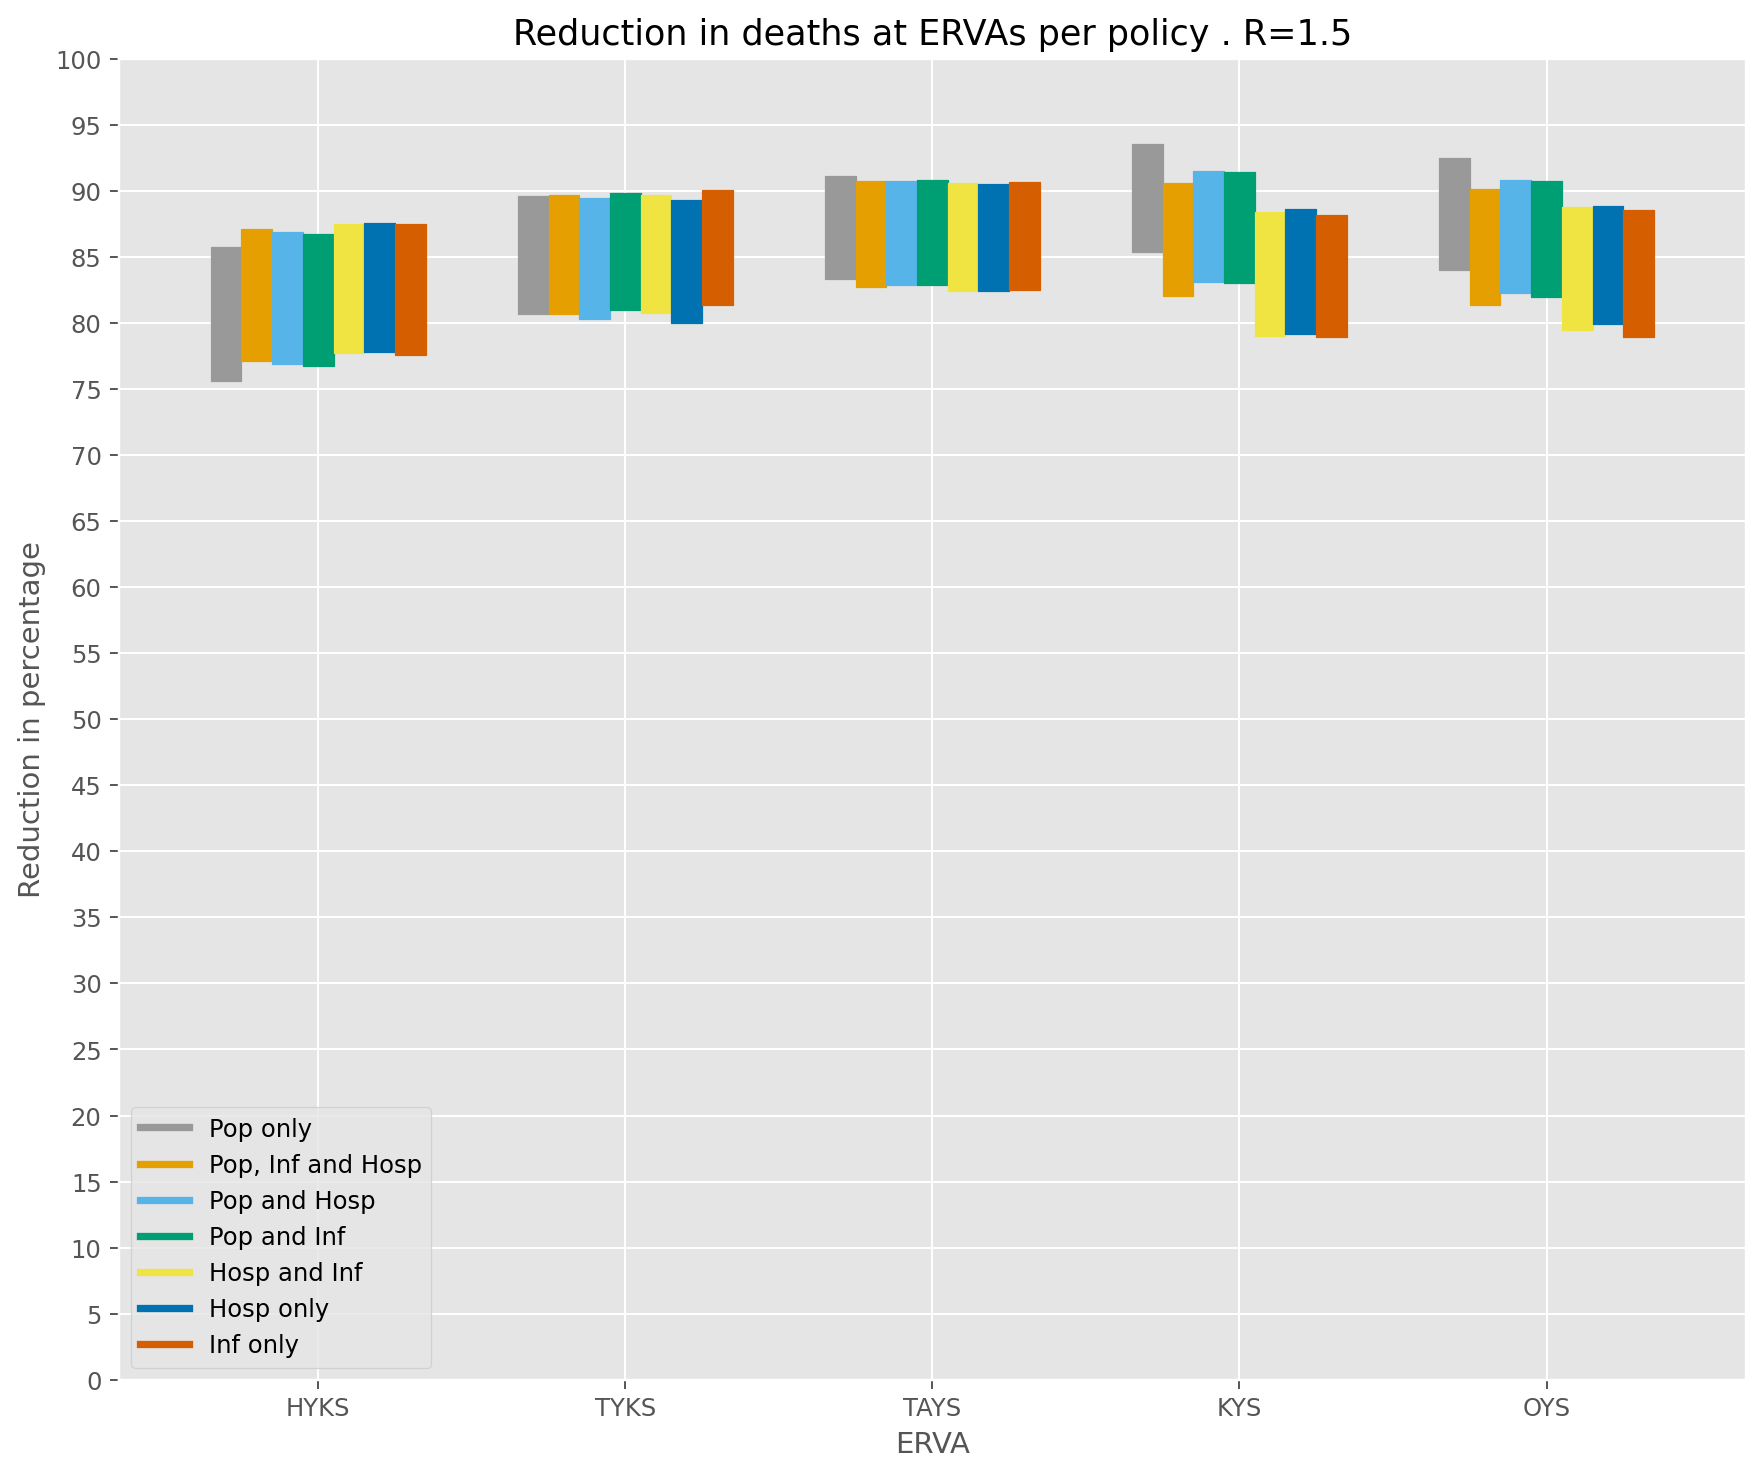

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[2], 'deaths', all_results, ervas_labels)

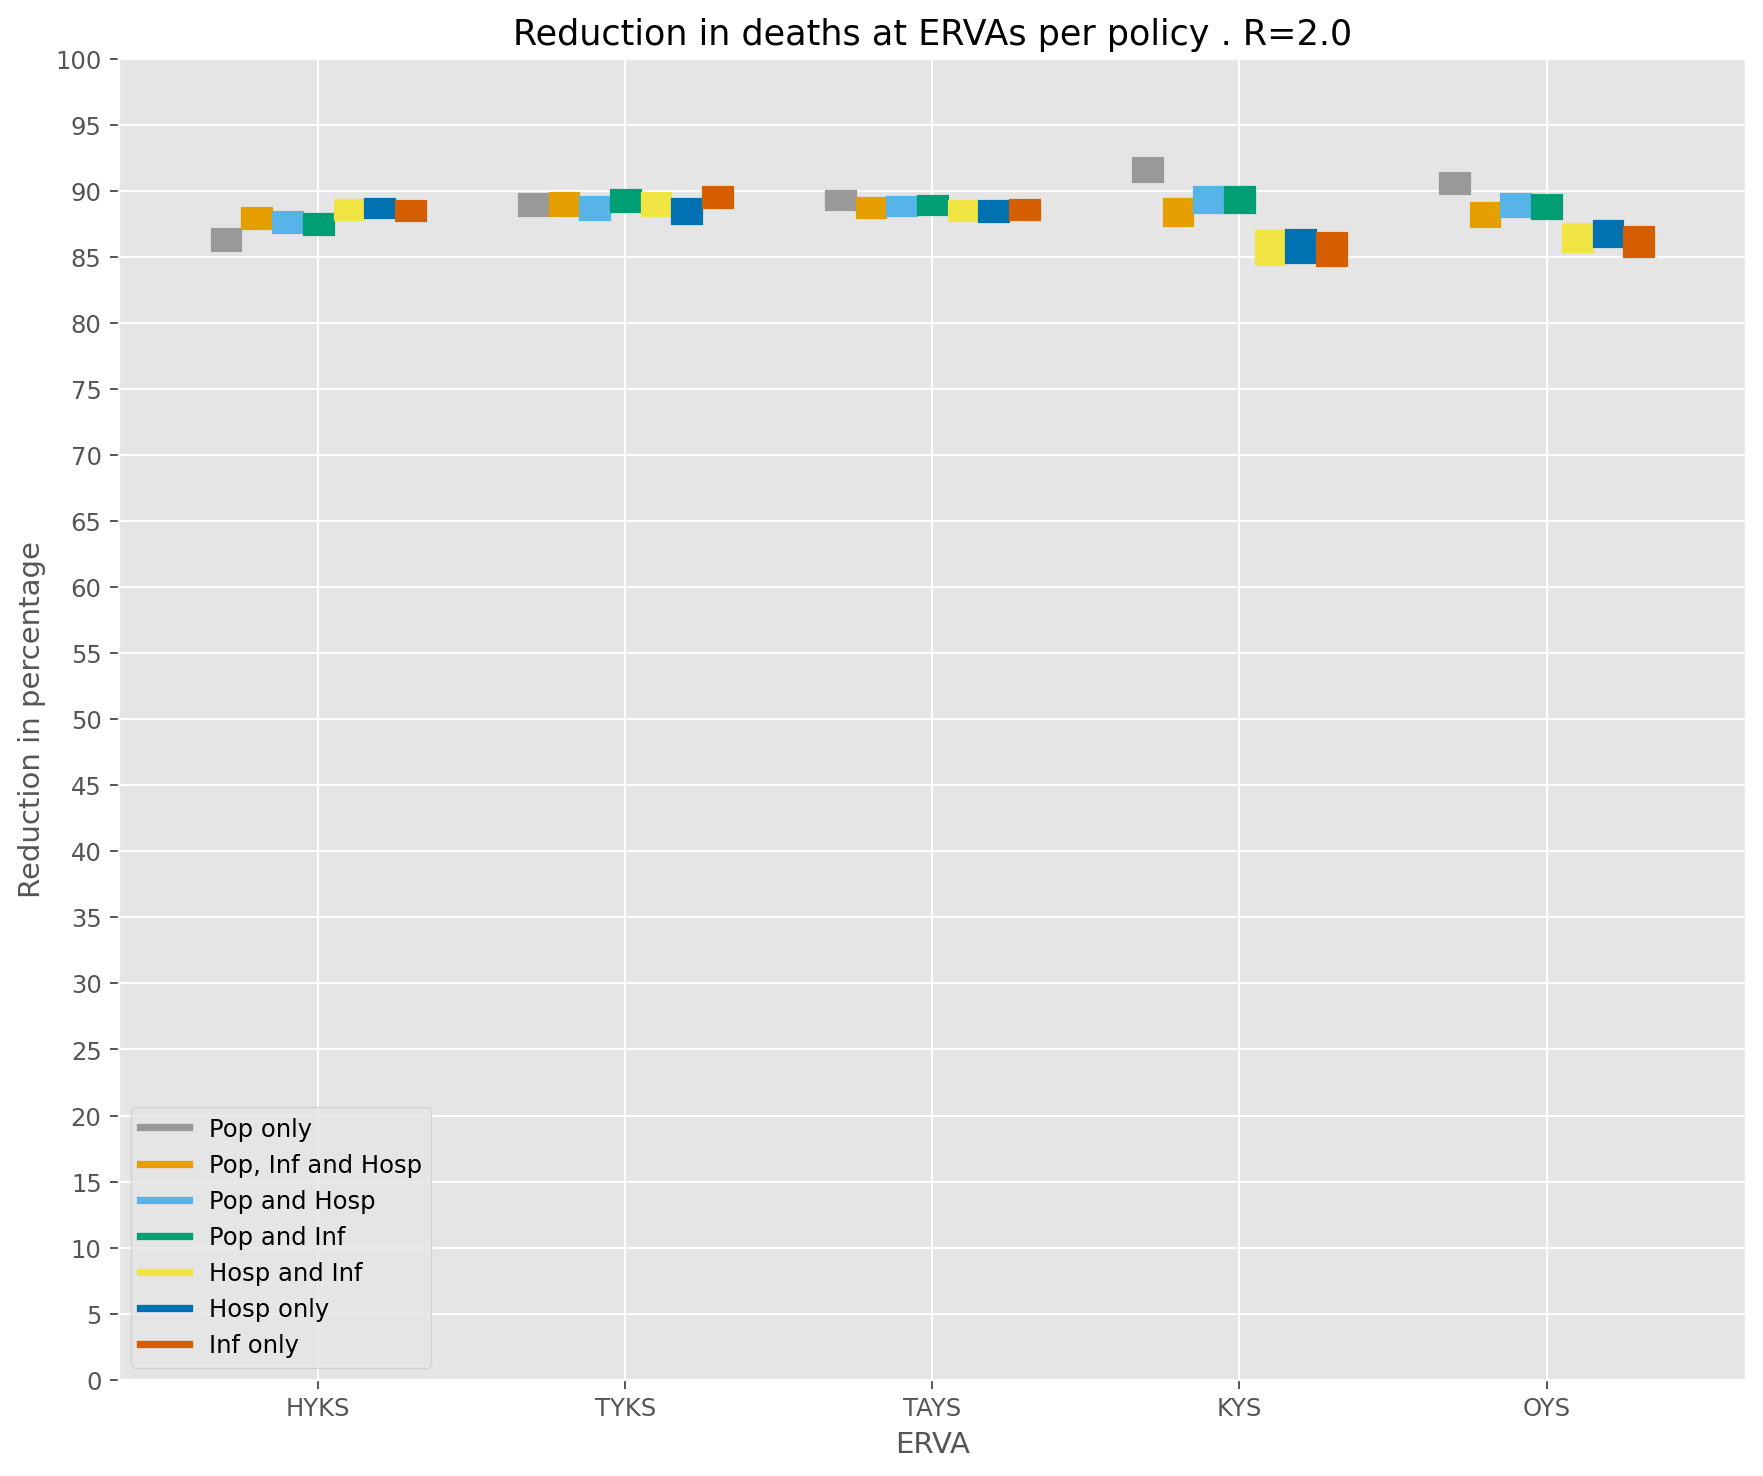

In [9]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[3], 'deaths', all_results, ervas_labels)

# Hospitalizations at ERVAs

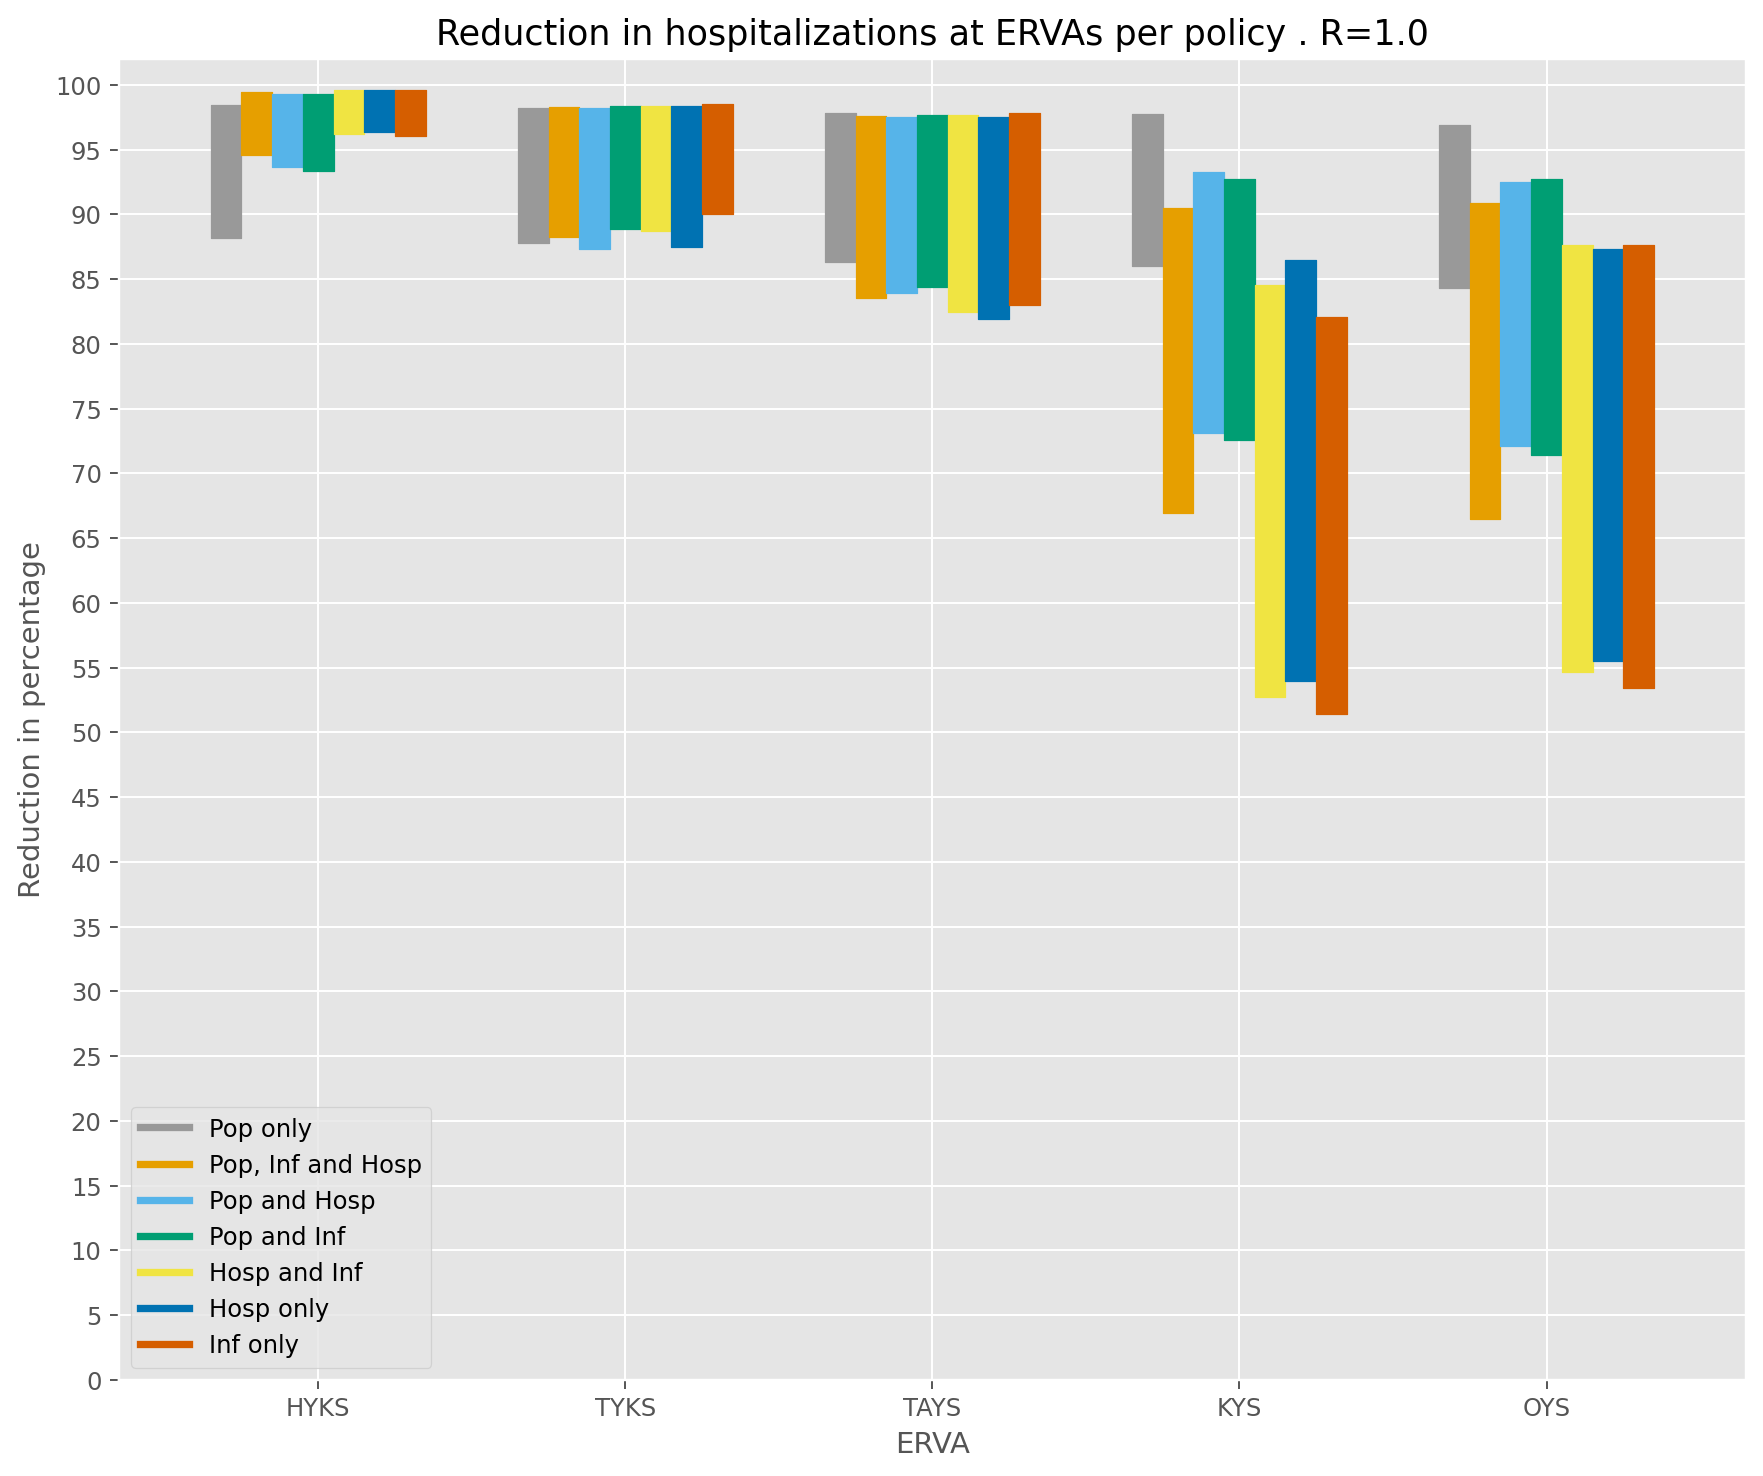

In [10]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[0], 'hospitalizations', all_results, ervas_labels)

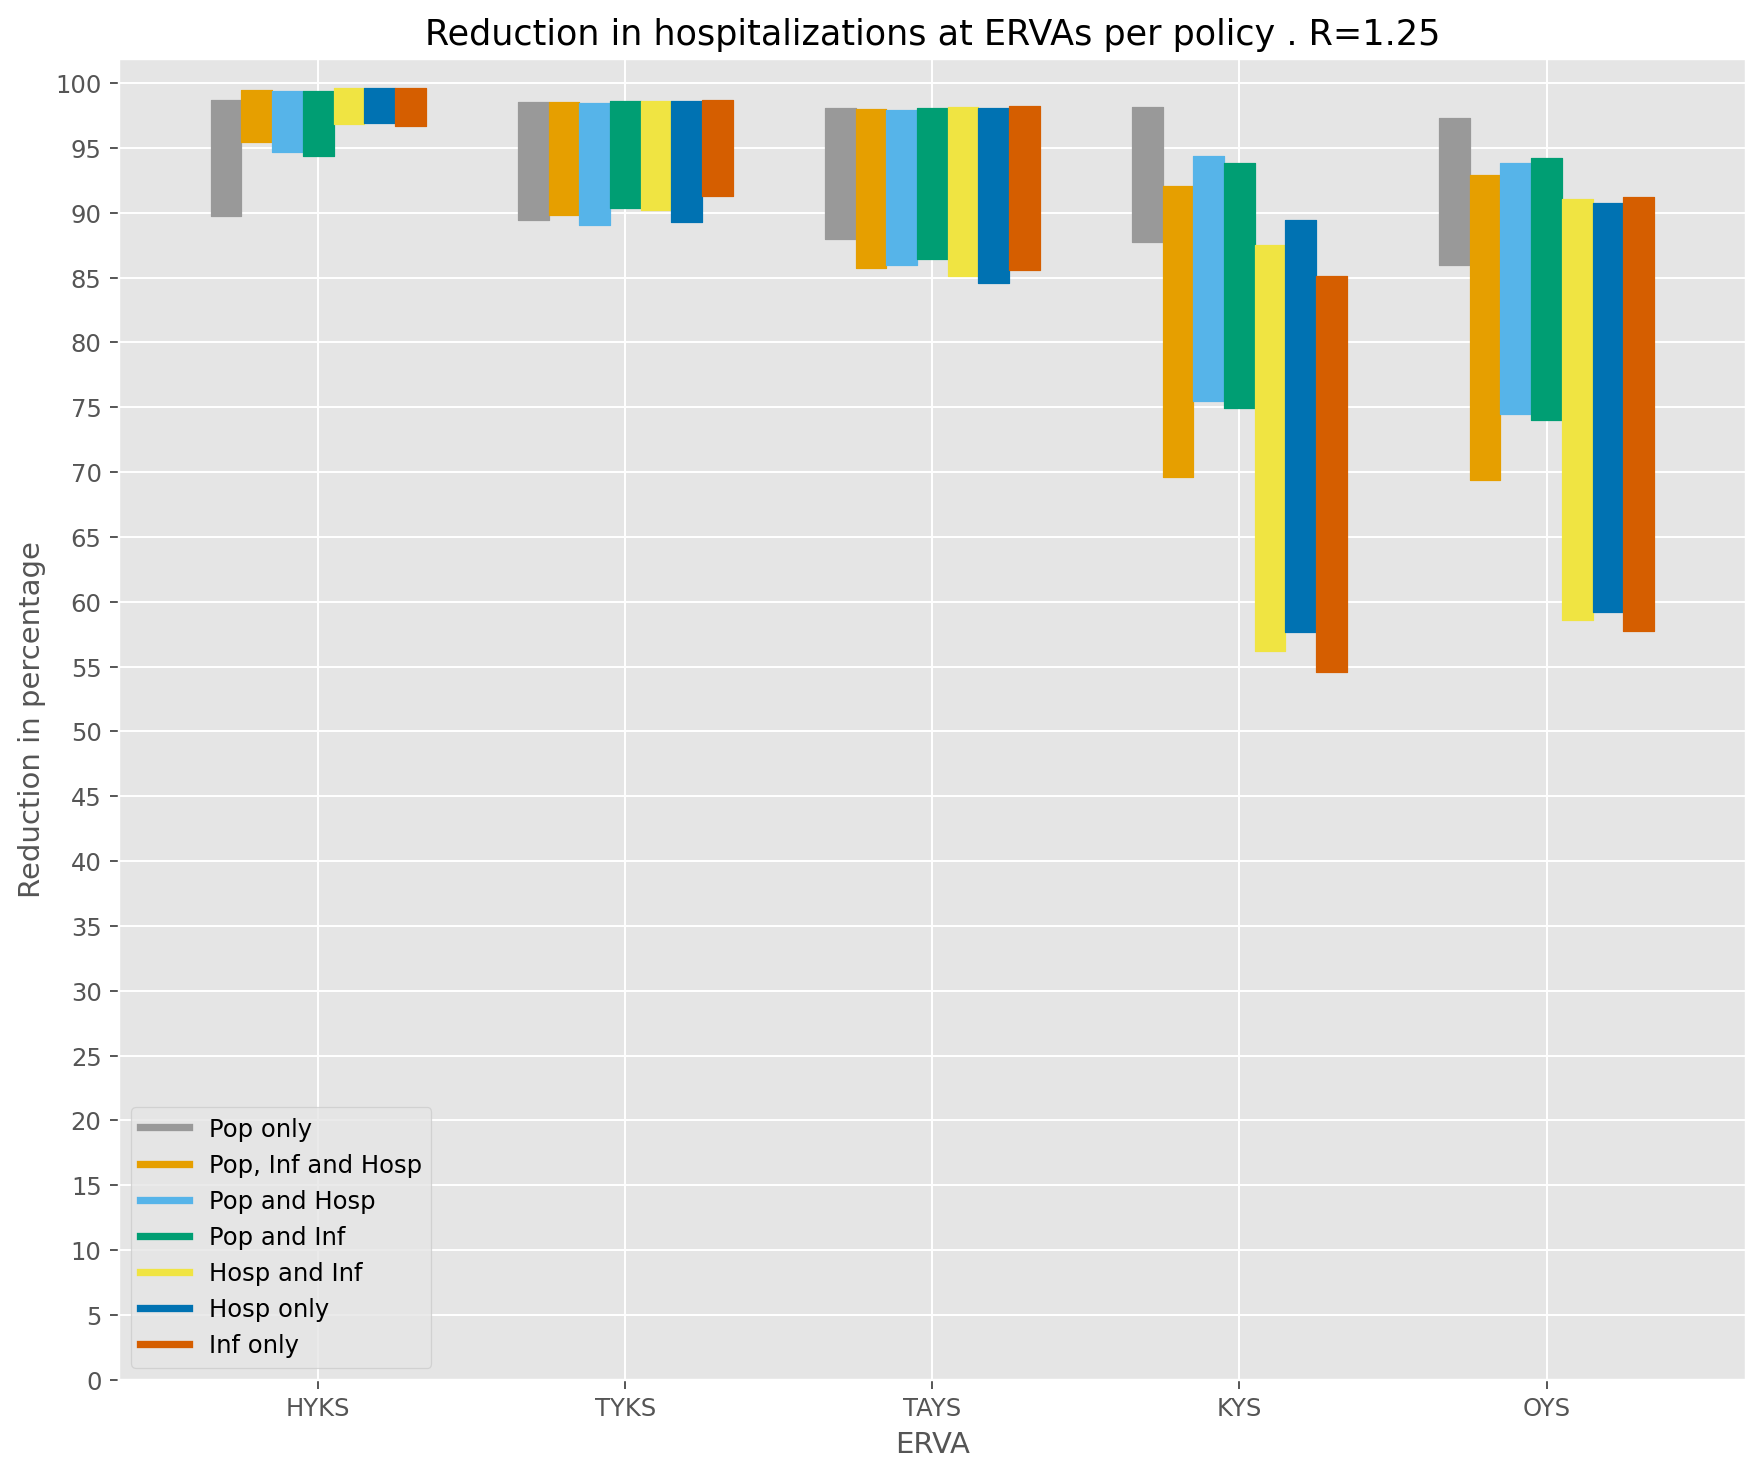

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[1], 'hospitalizations', all_results, ervas_labels)

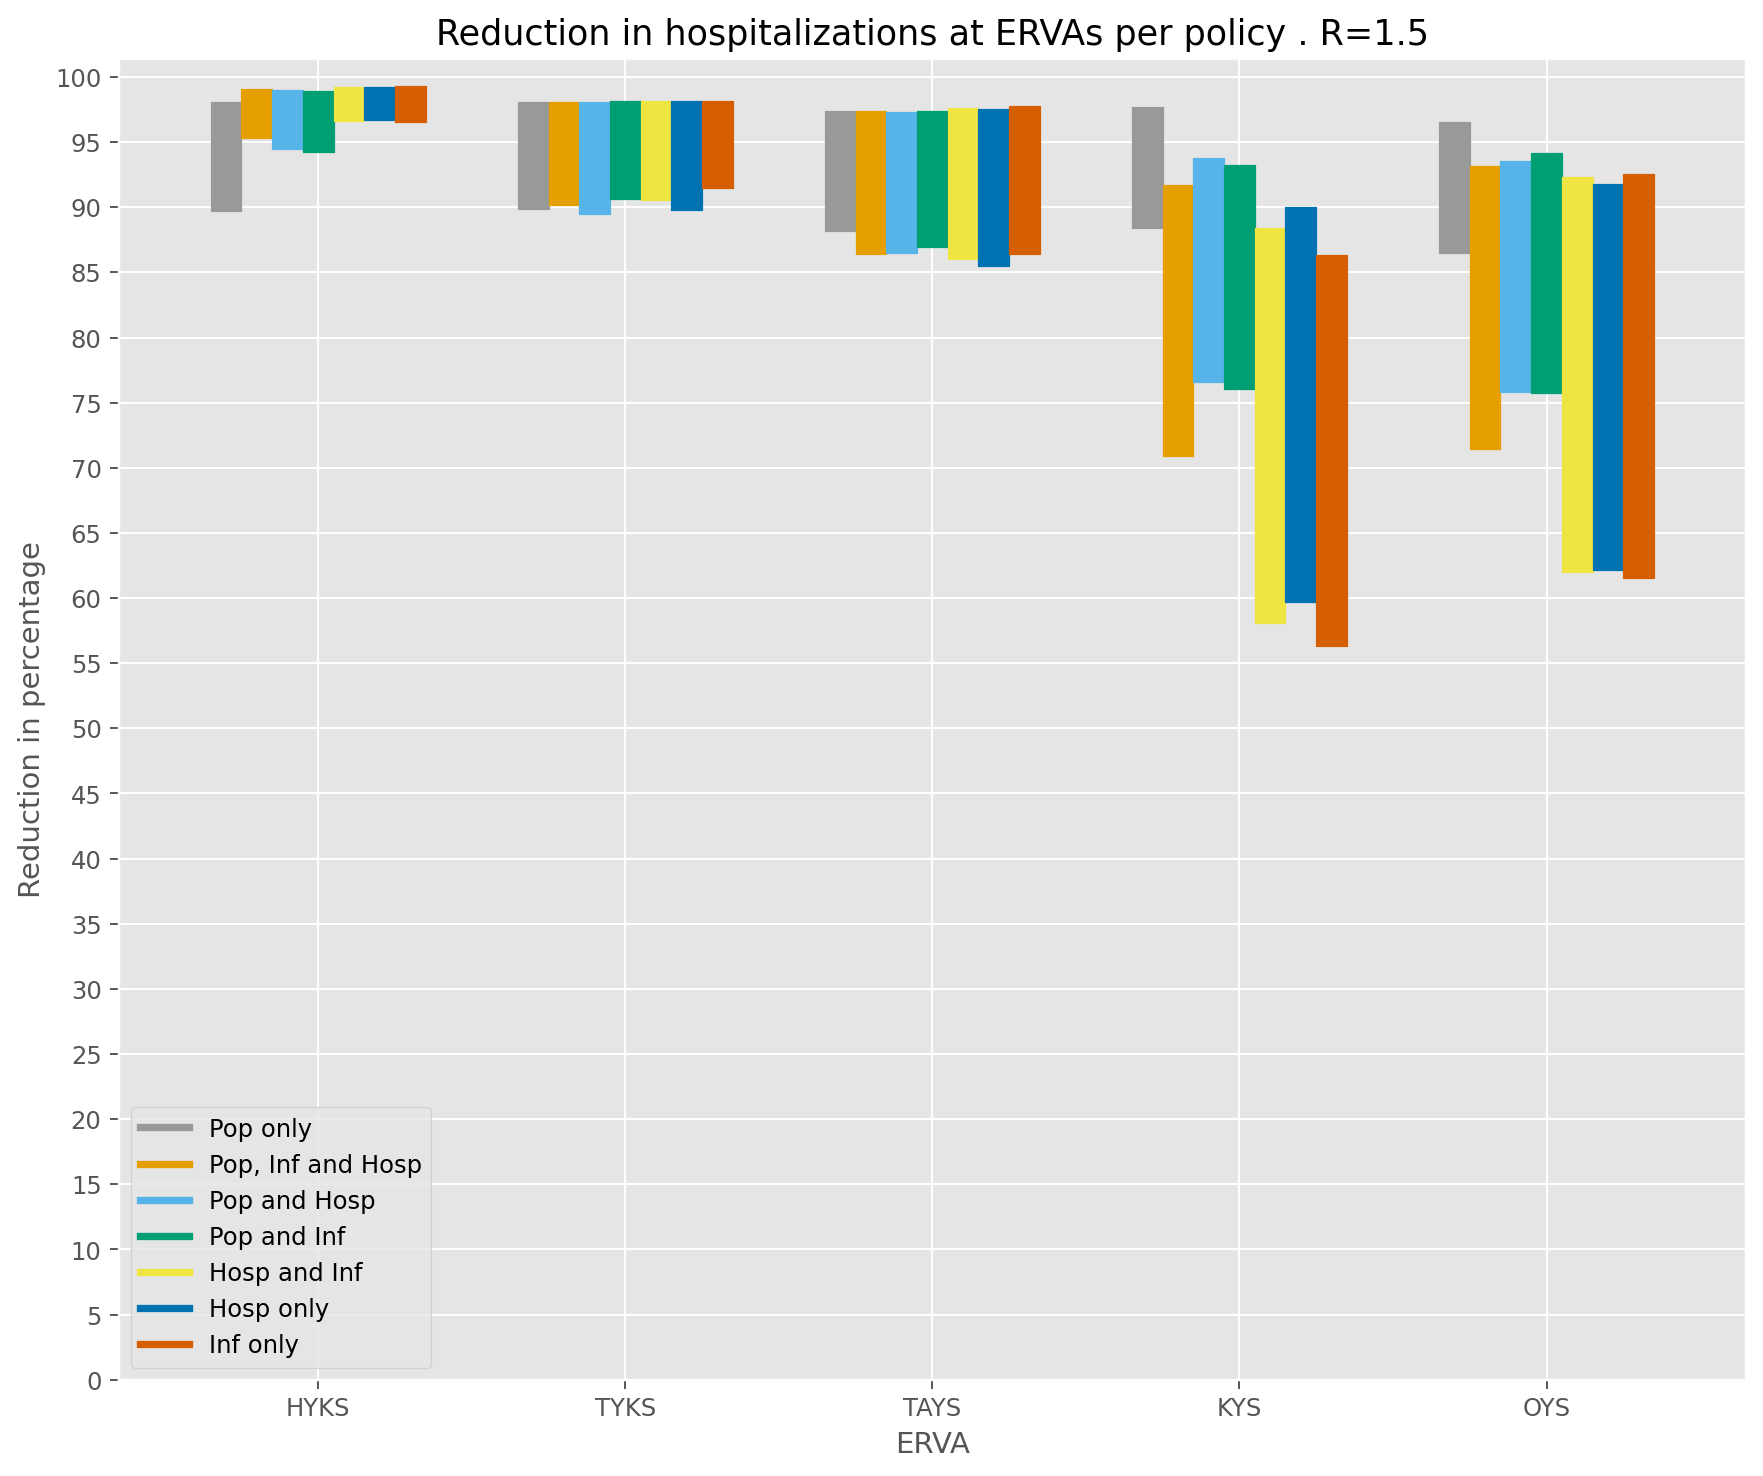

In [12]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[2], 'hospitalizations', all_results, ervas_labels)

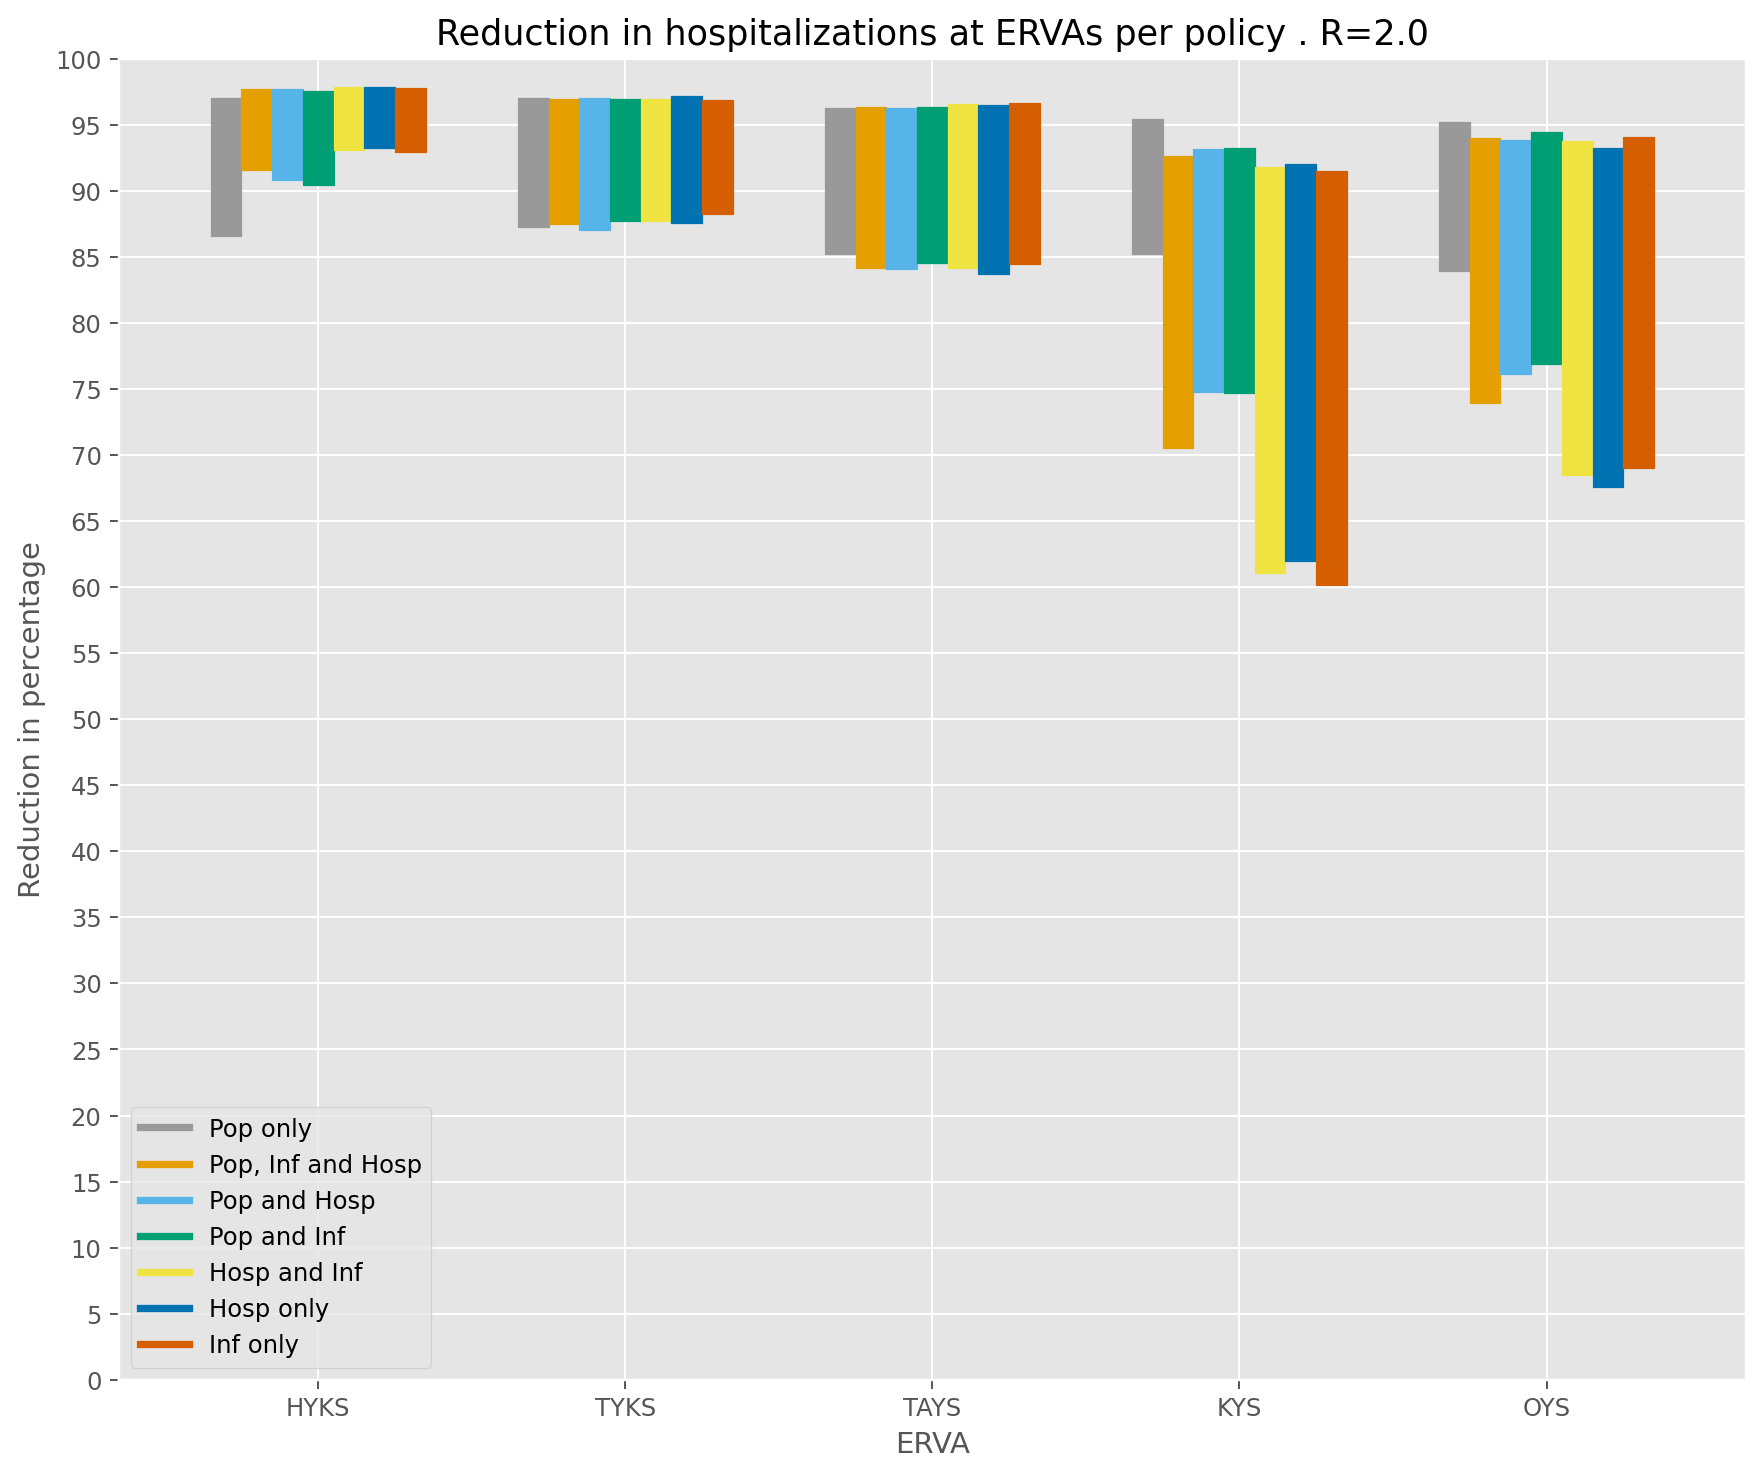

In [13]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[3], 'hospitalizations', all_results, ervas_labels)

# Infections at ERVAs

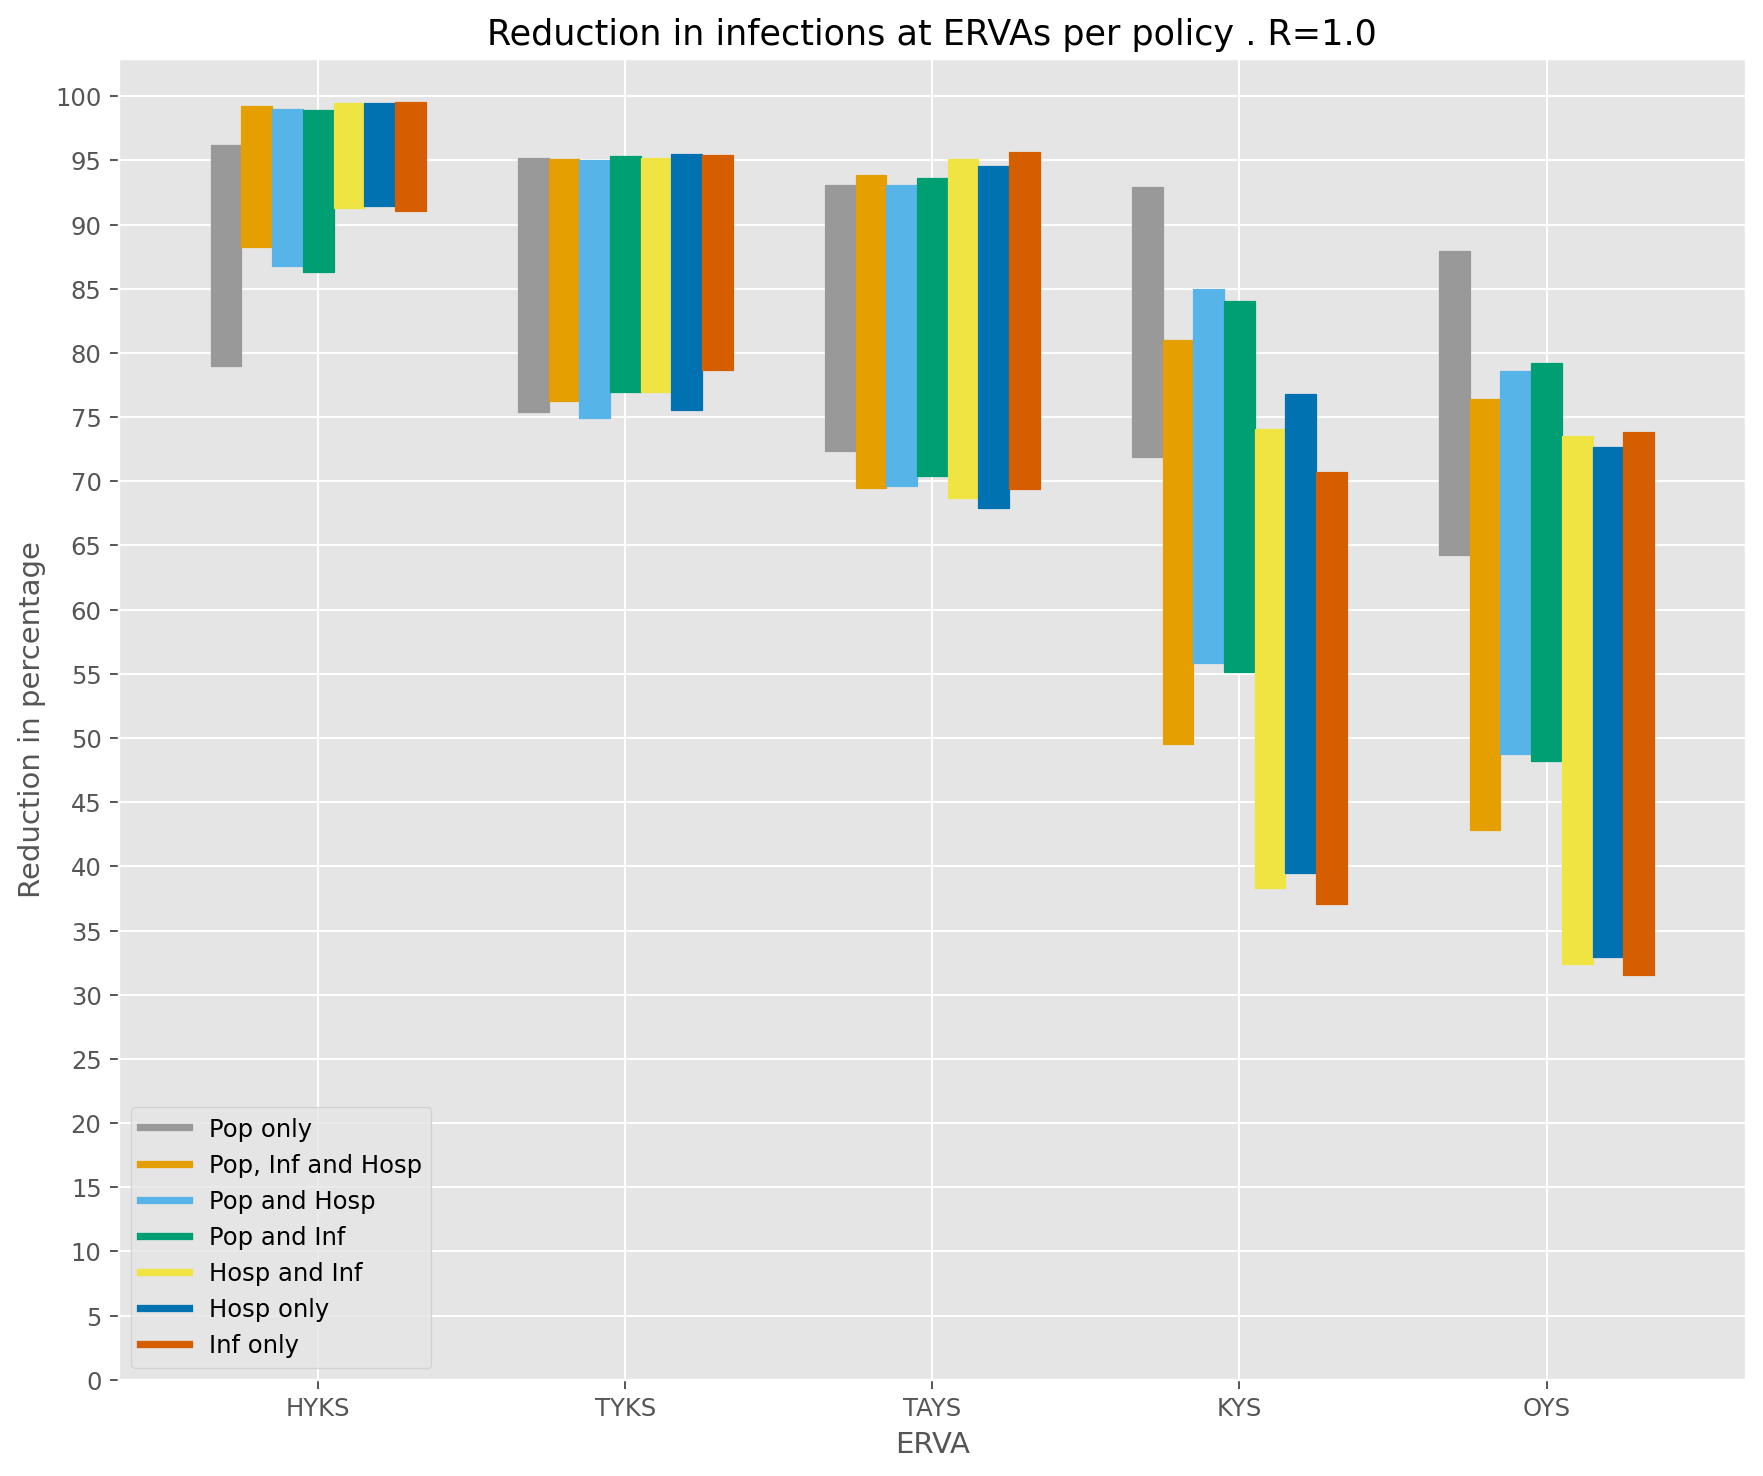

In [14]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[0], 'infections', all_results, ervas_labels)

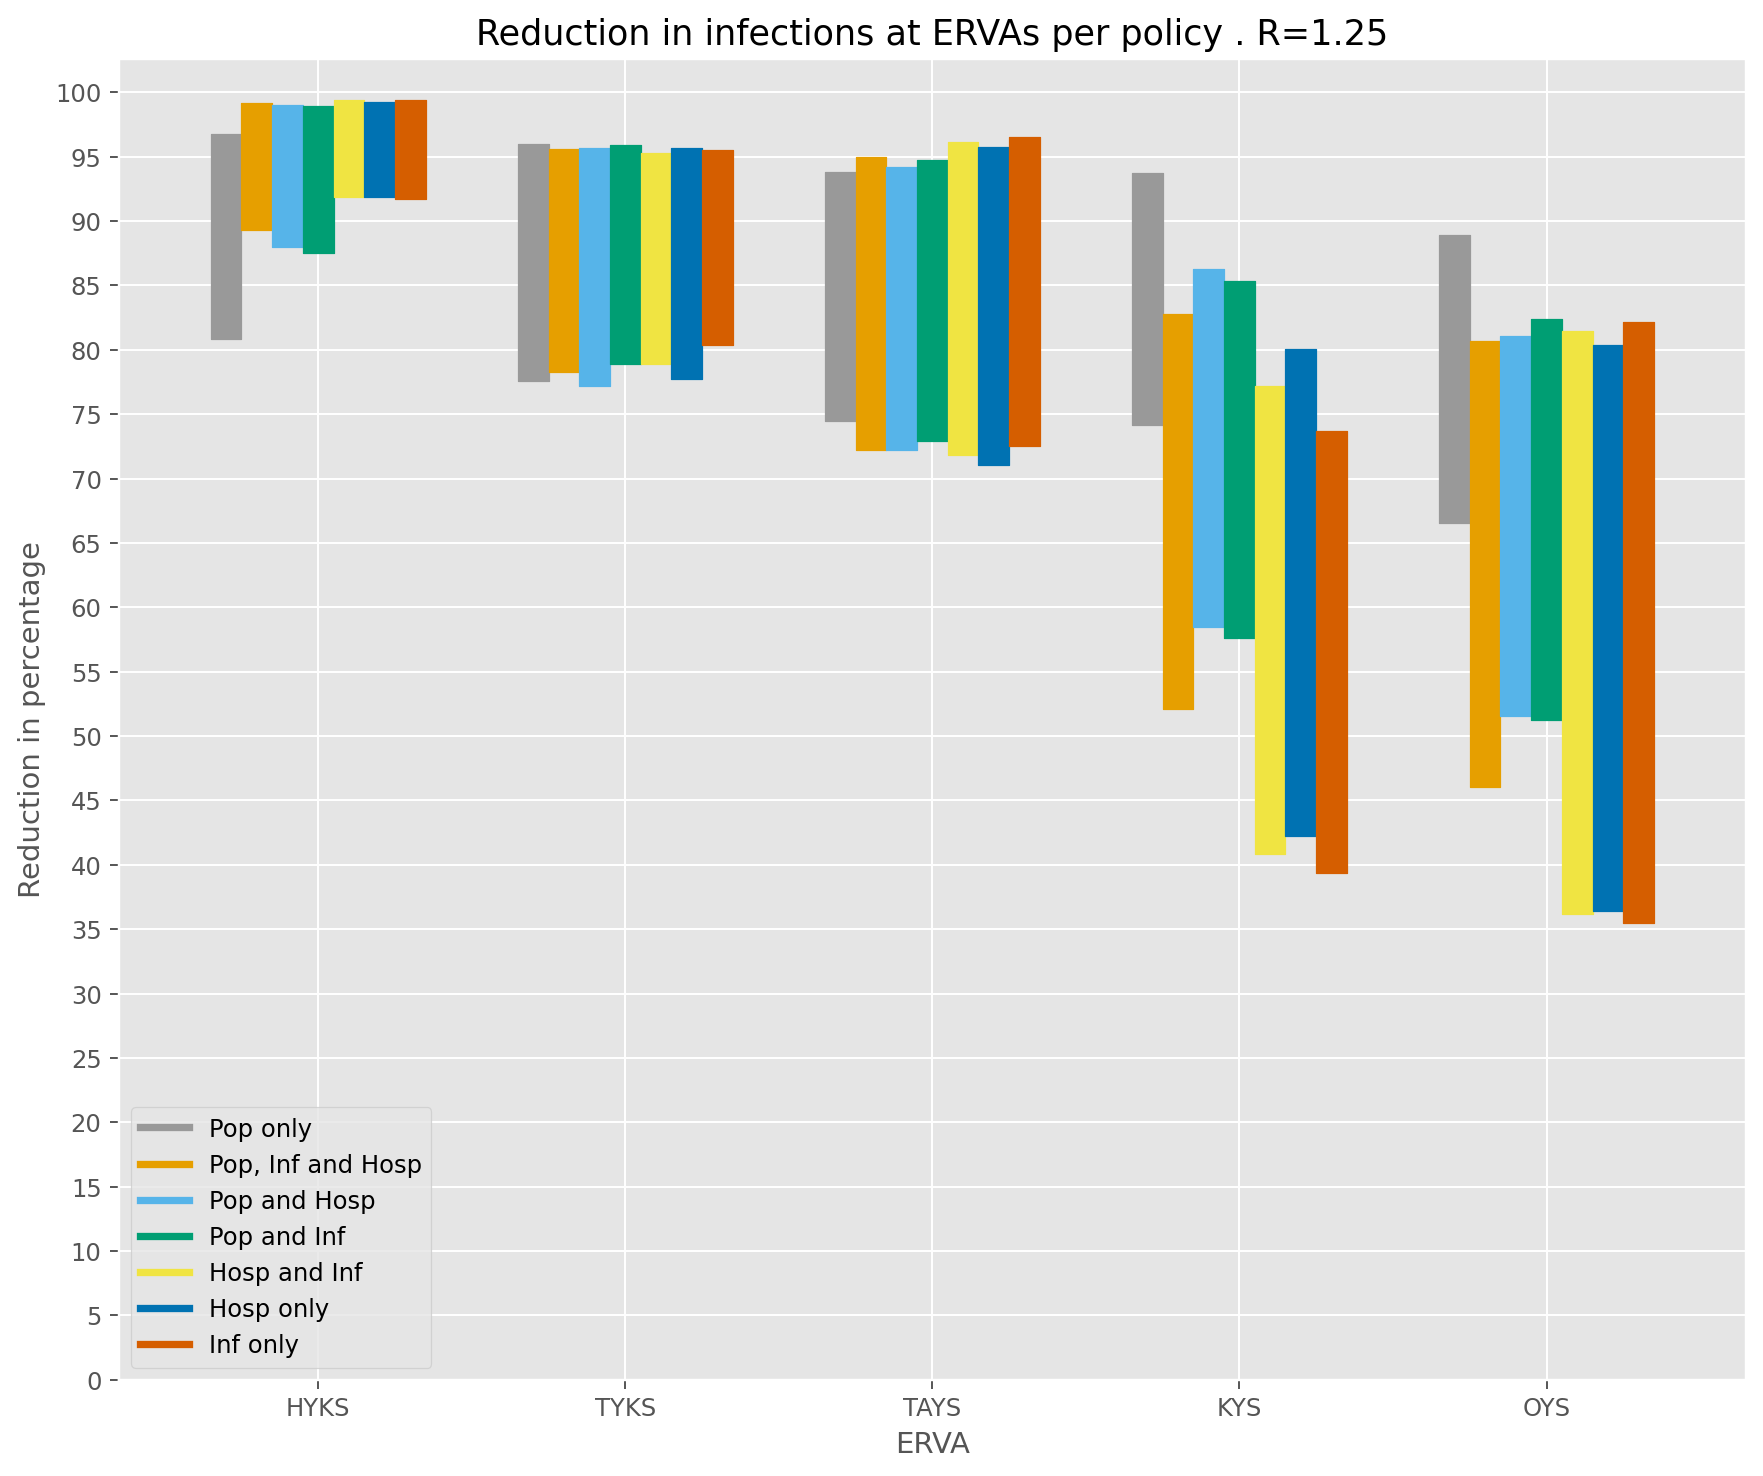

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[1], 'infections', all_results, ervas_labels)

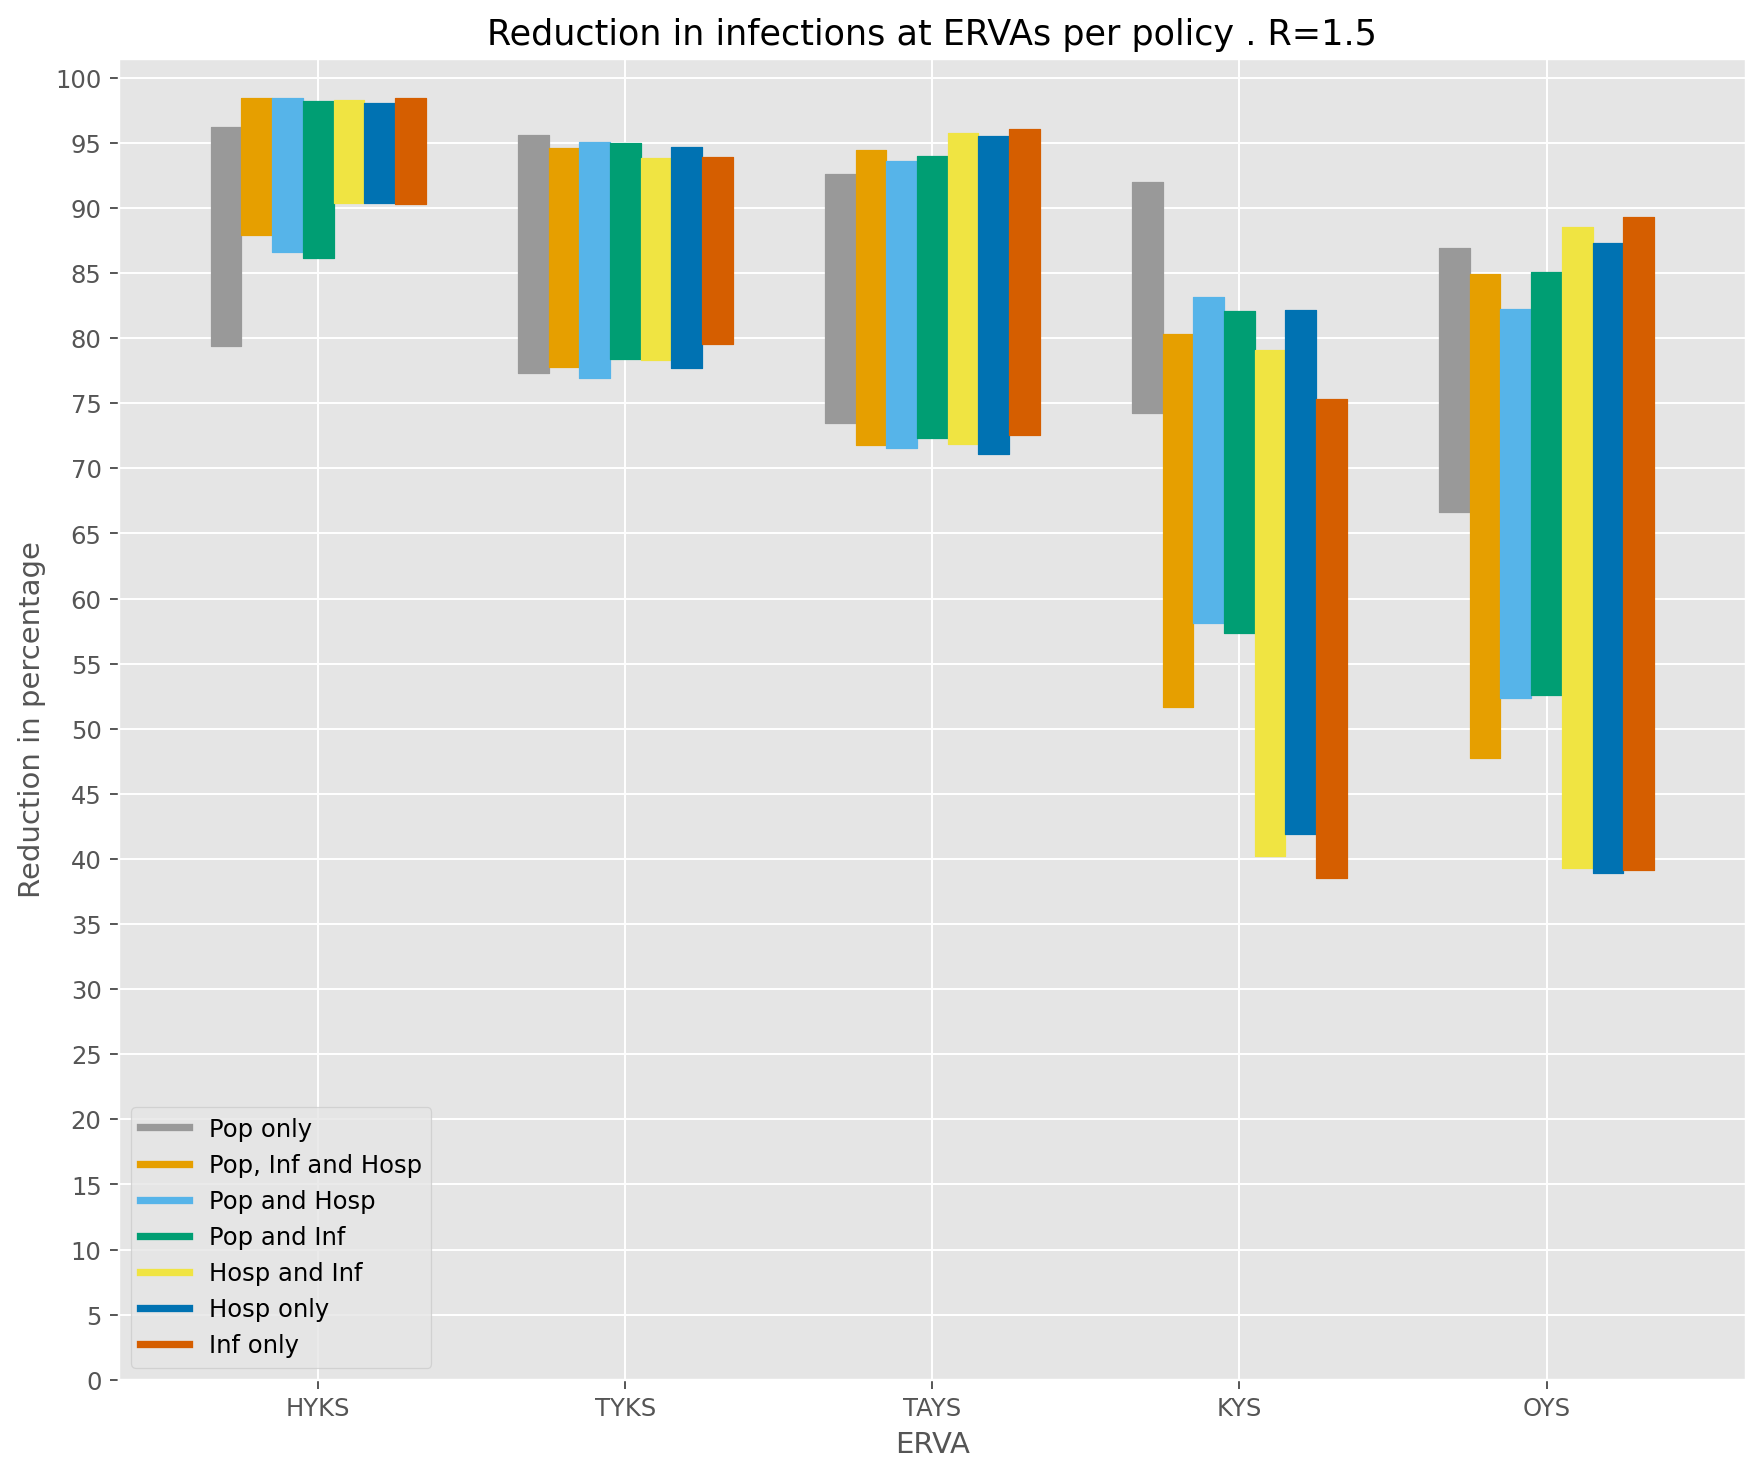

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[2], 'infections', all_results, ervas_labels)

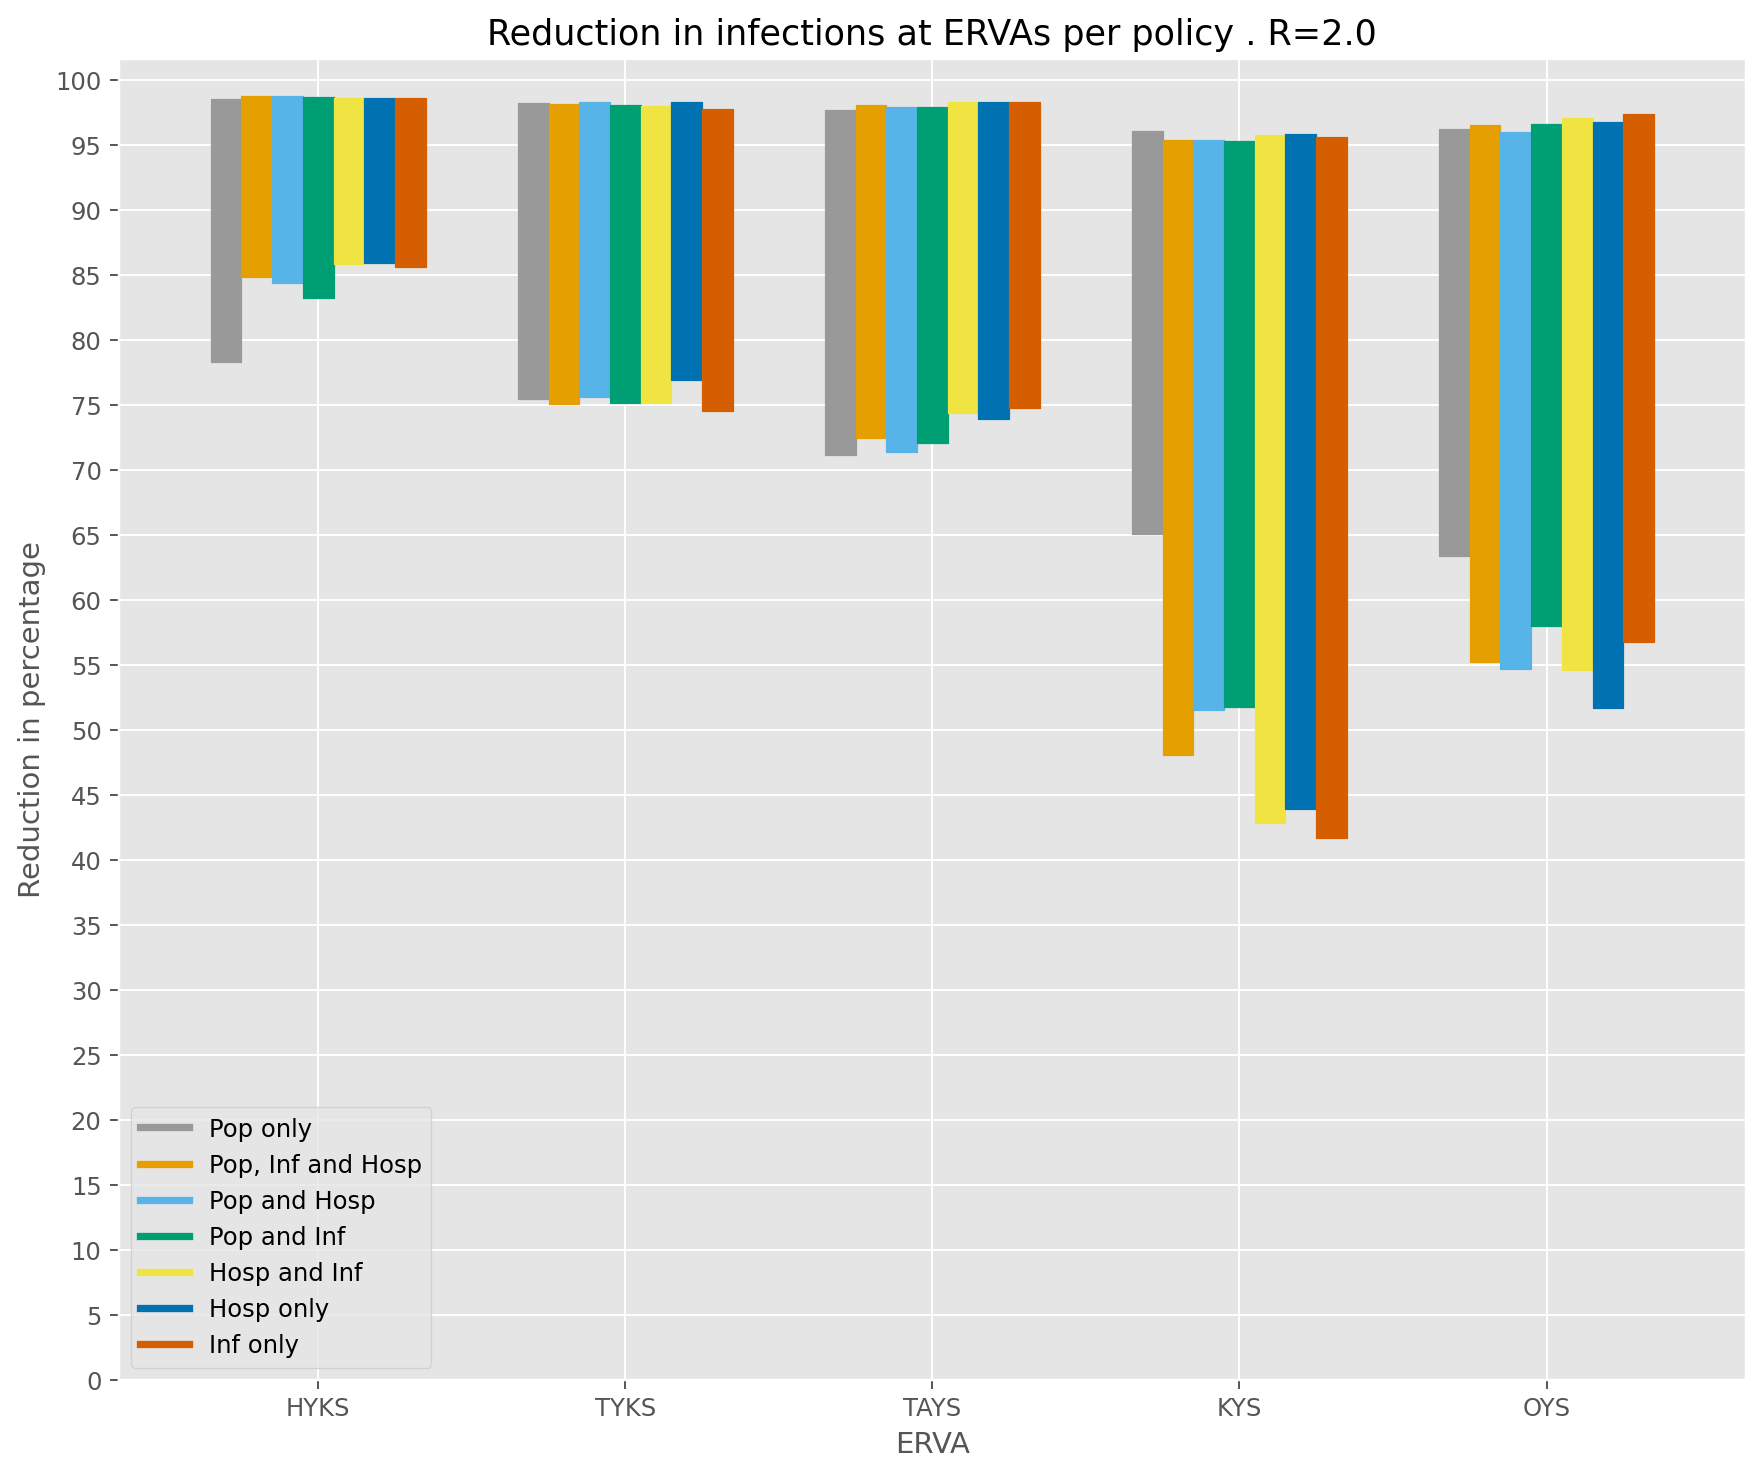

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_ervas(ax, r_experiments[3], 'infections', all_results, ervas_labels)

# Deaths at age groups

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


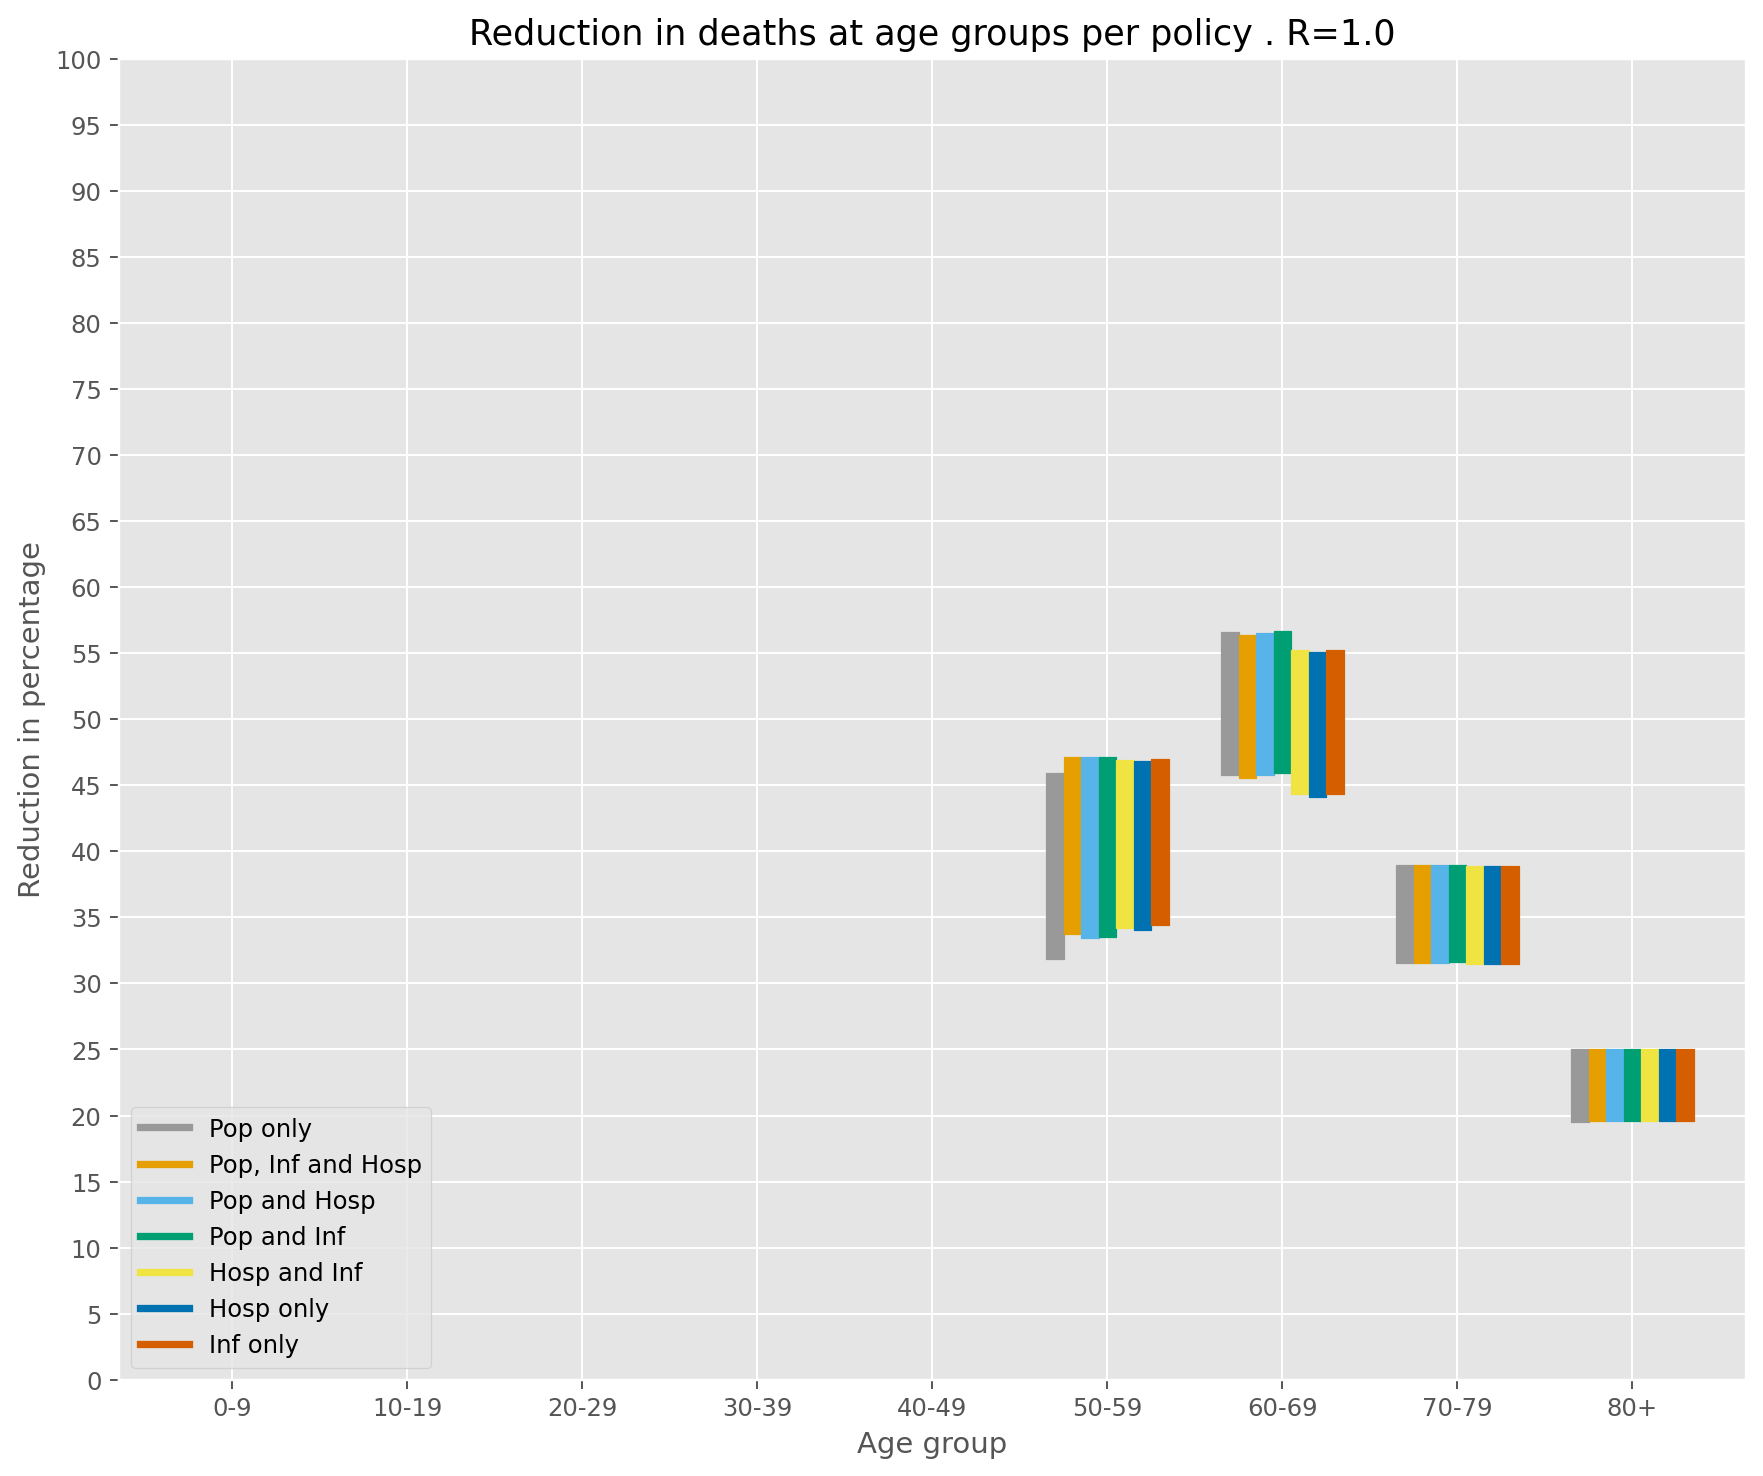

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[0], 'deaths', all_results, age_labels)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


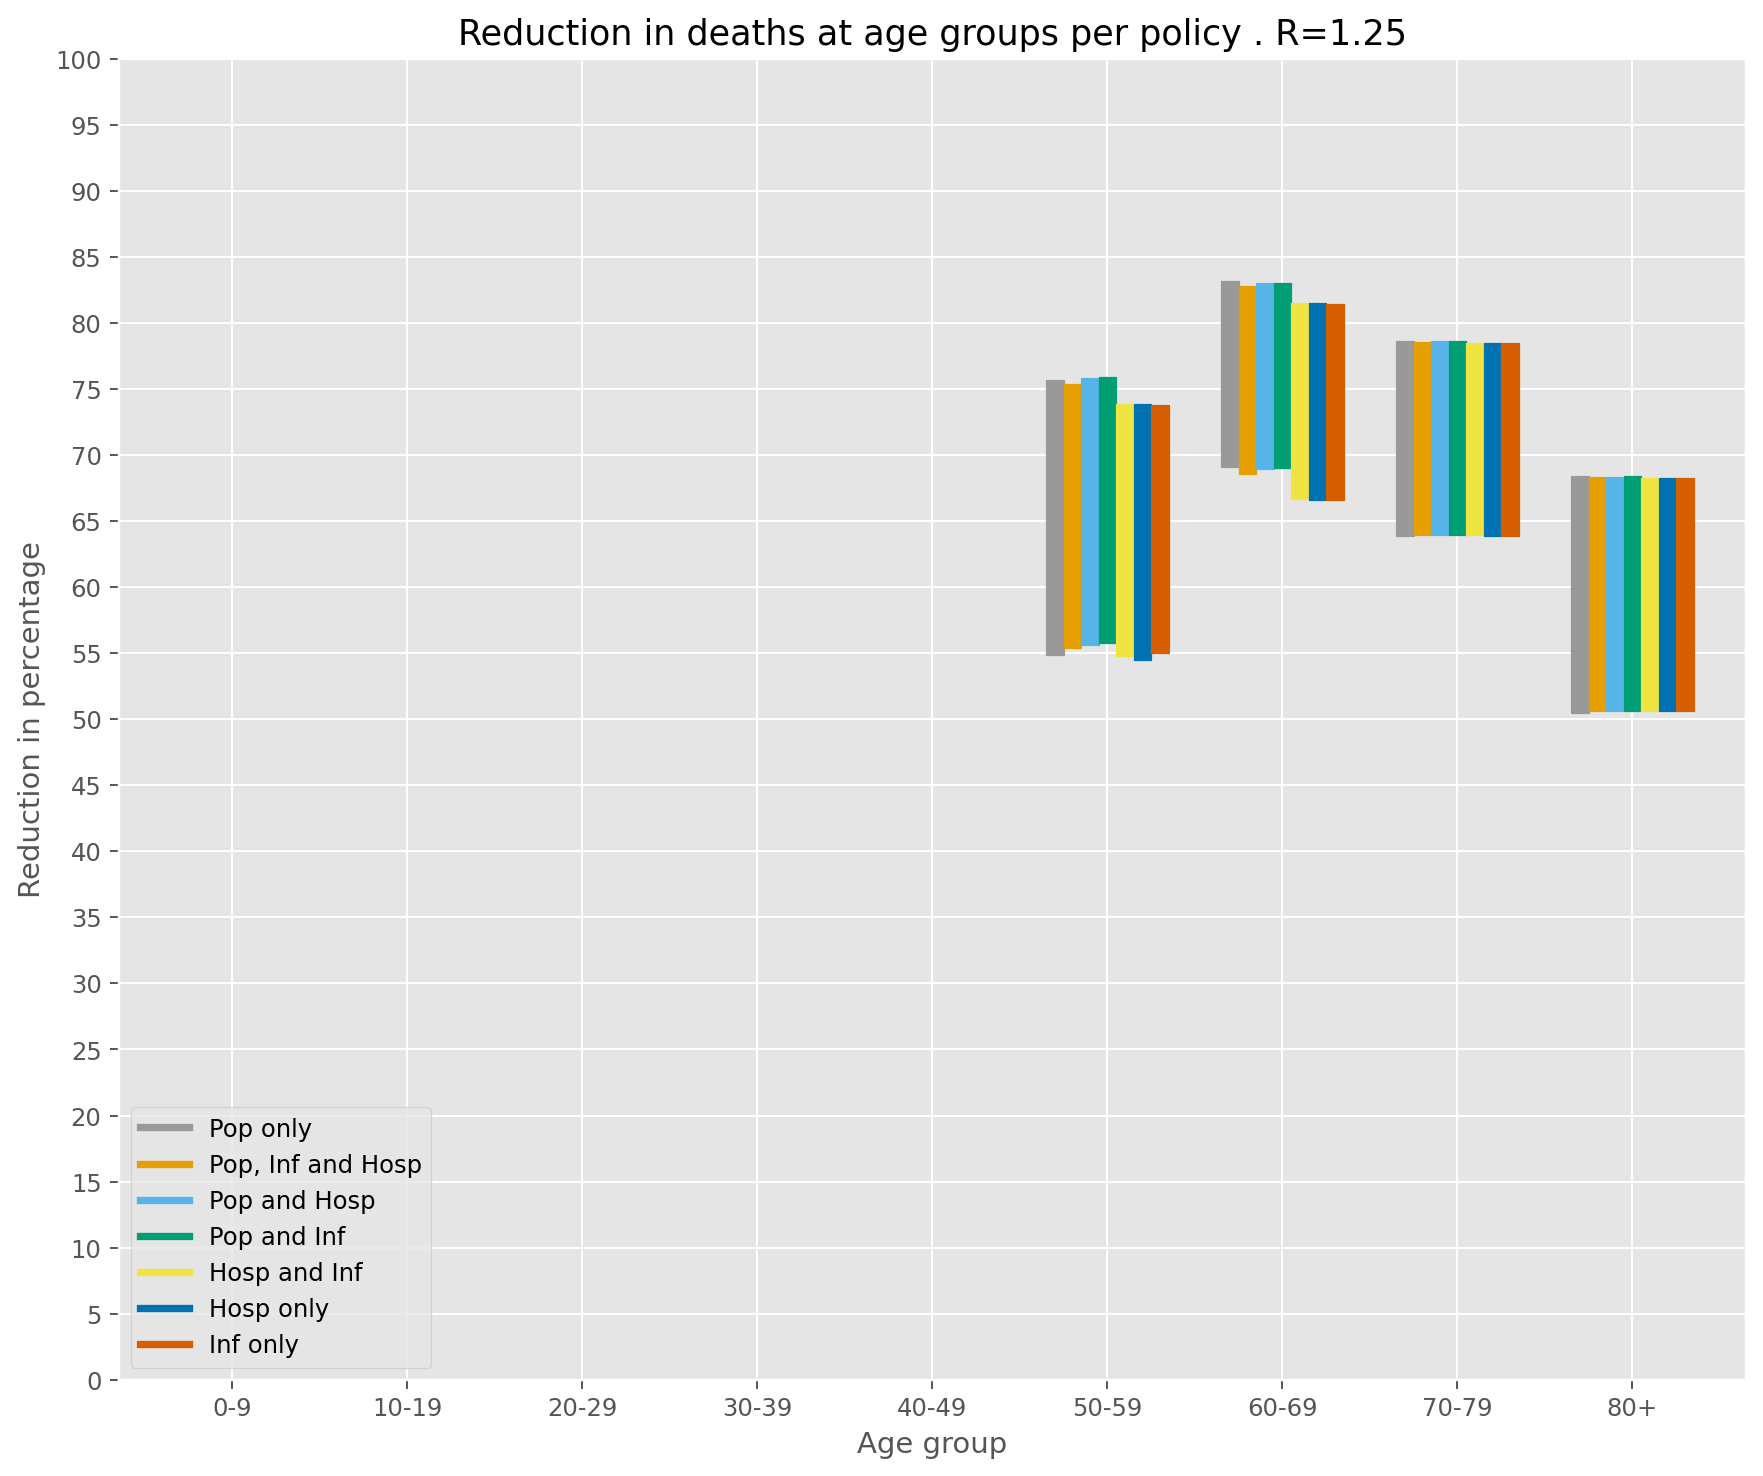

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[1], 'deaths', all_results, age_labels)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


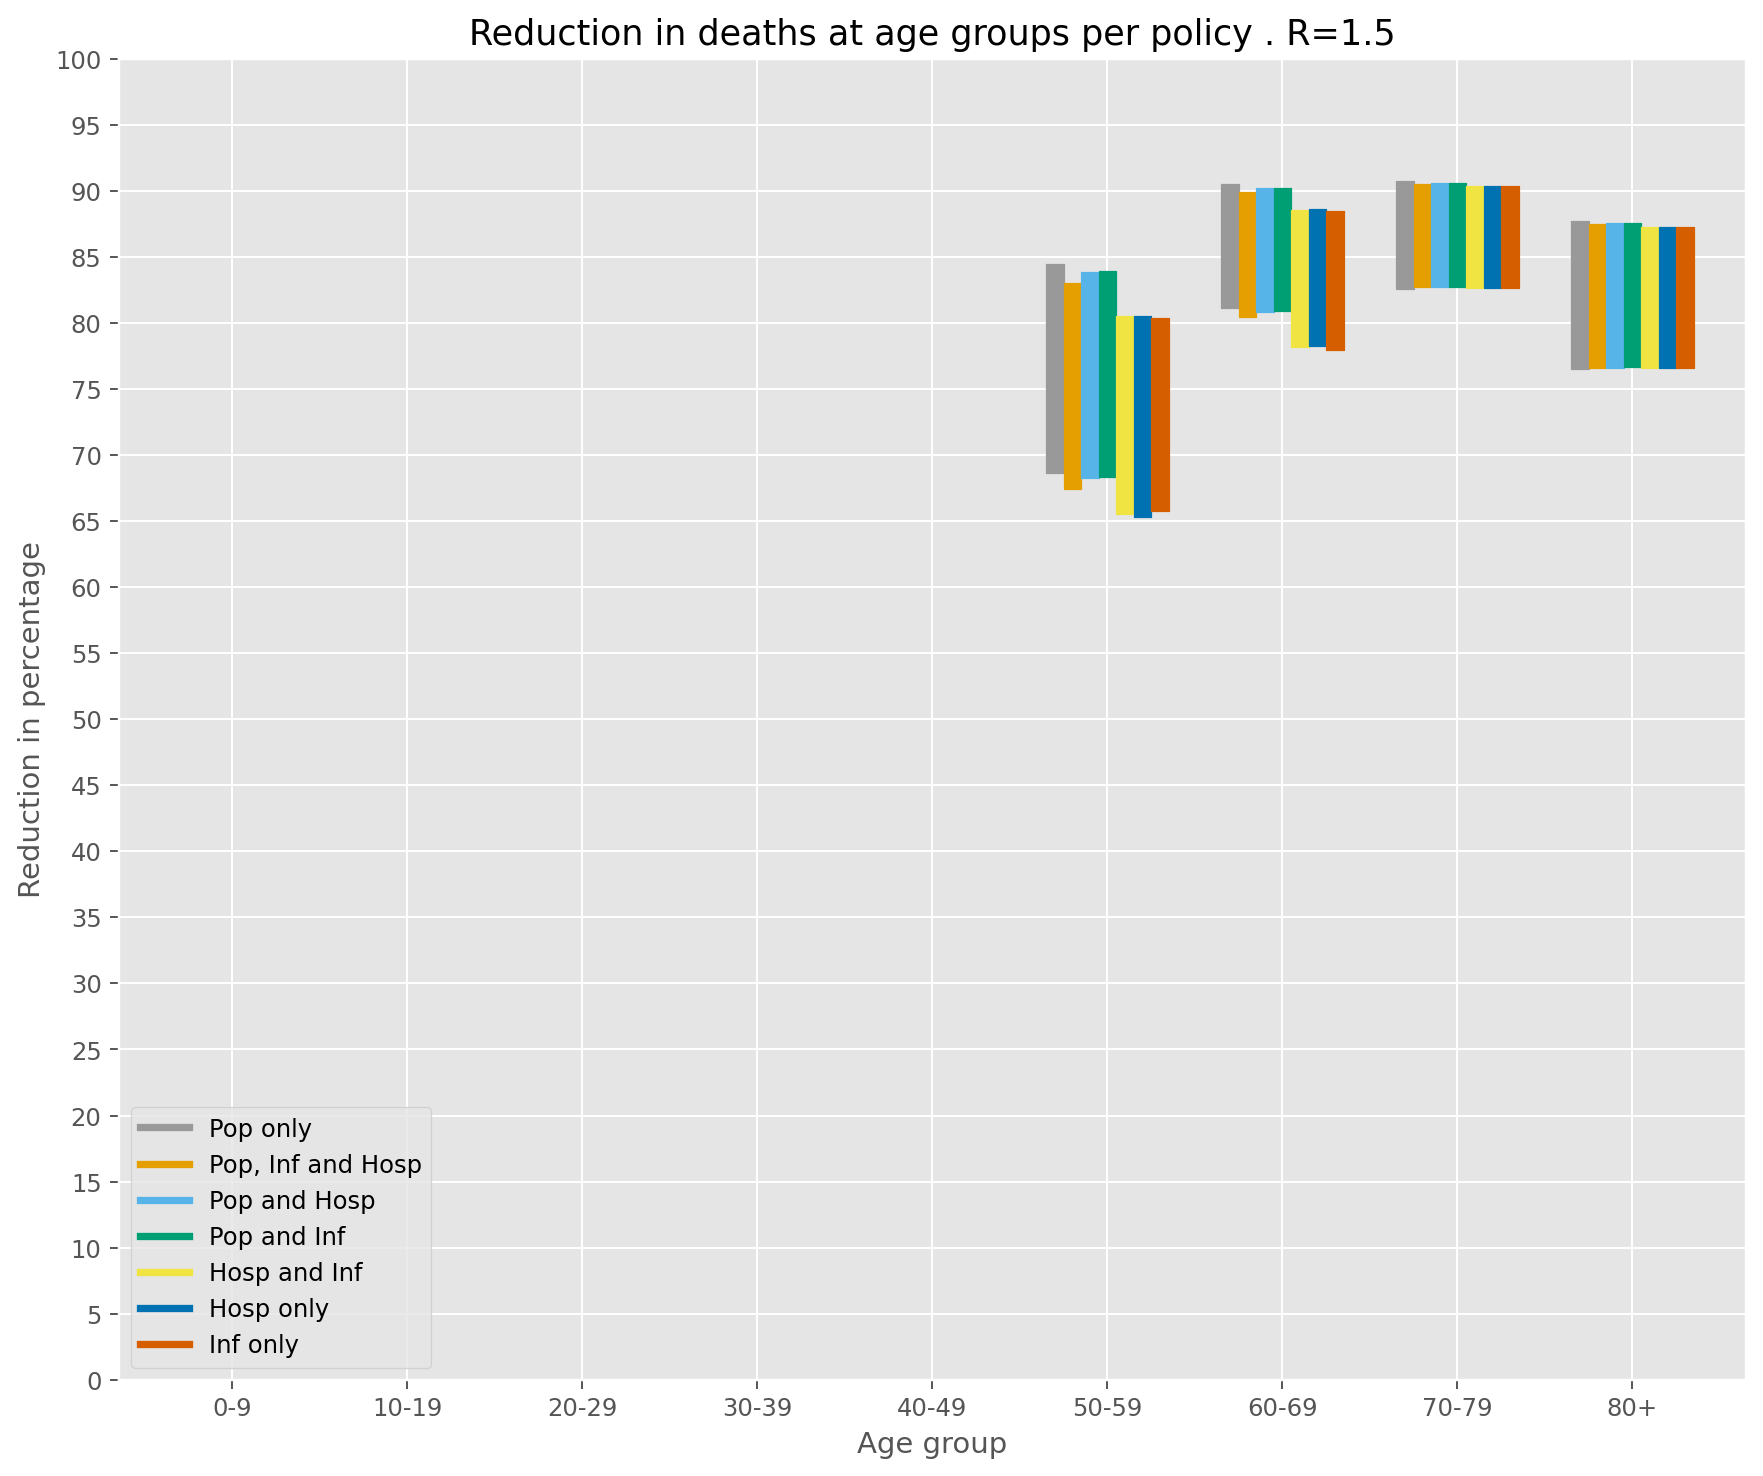

In [20]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[2], 'deaths', all_results, age_labels)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


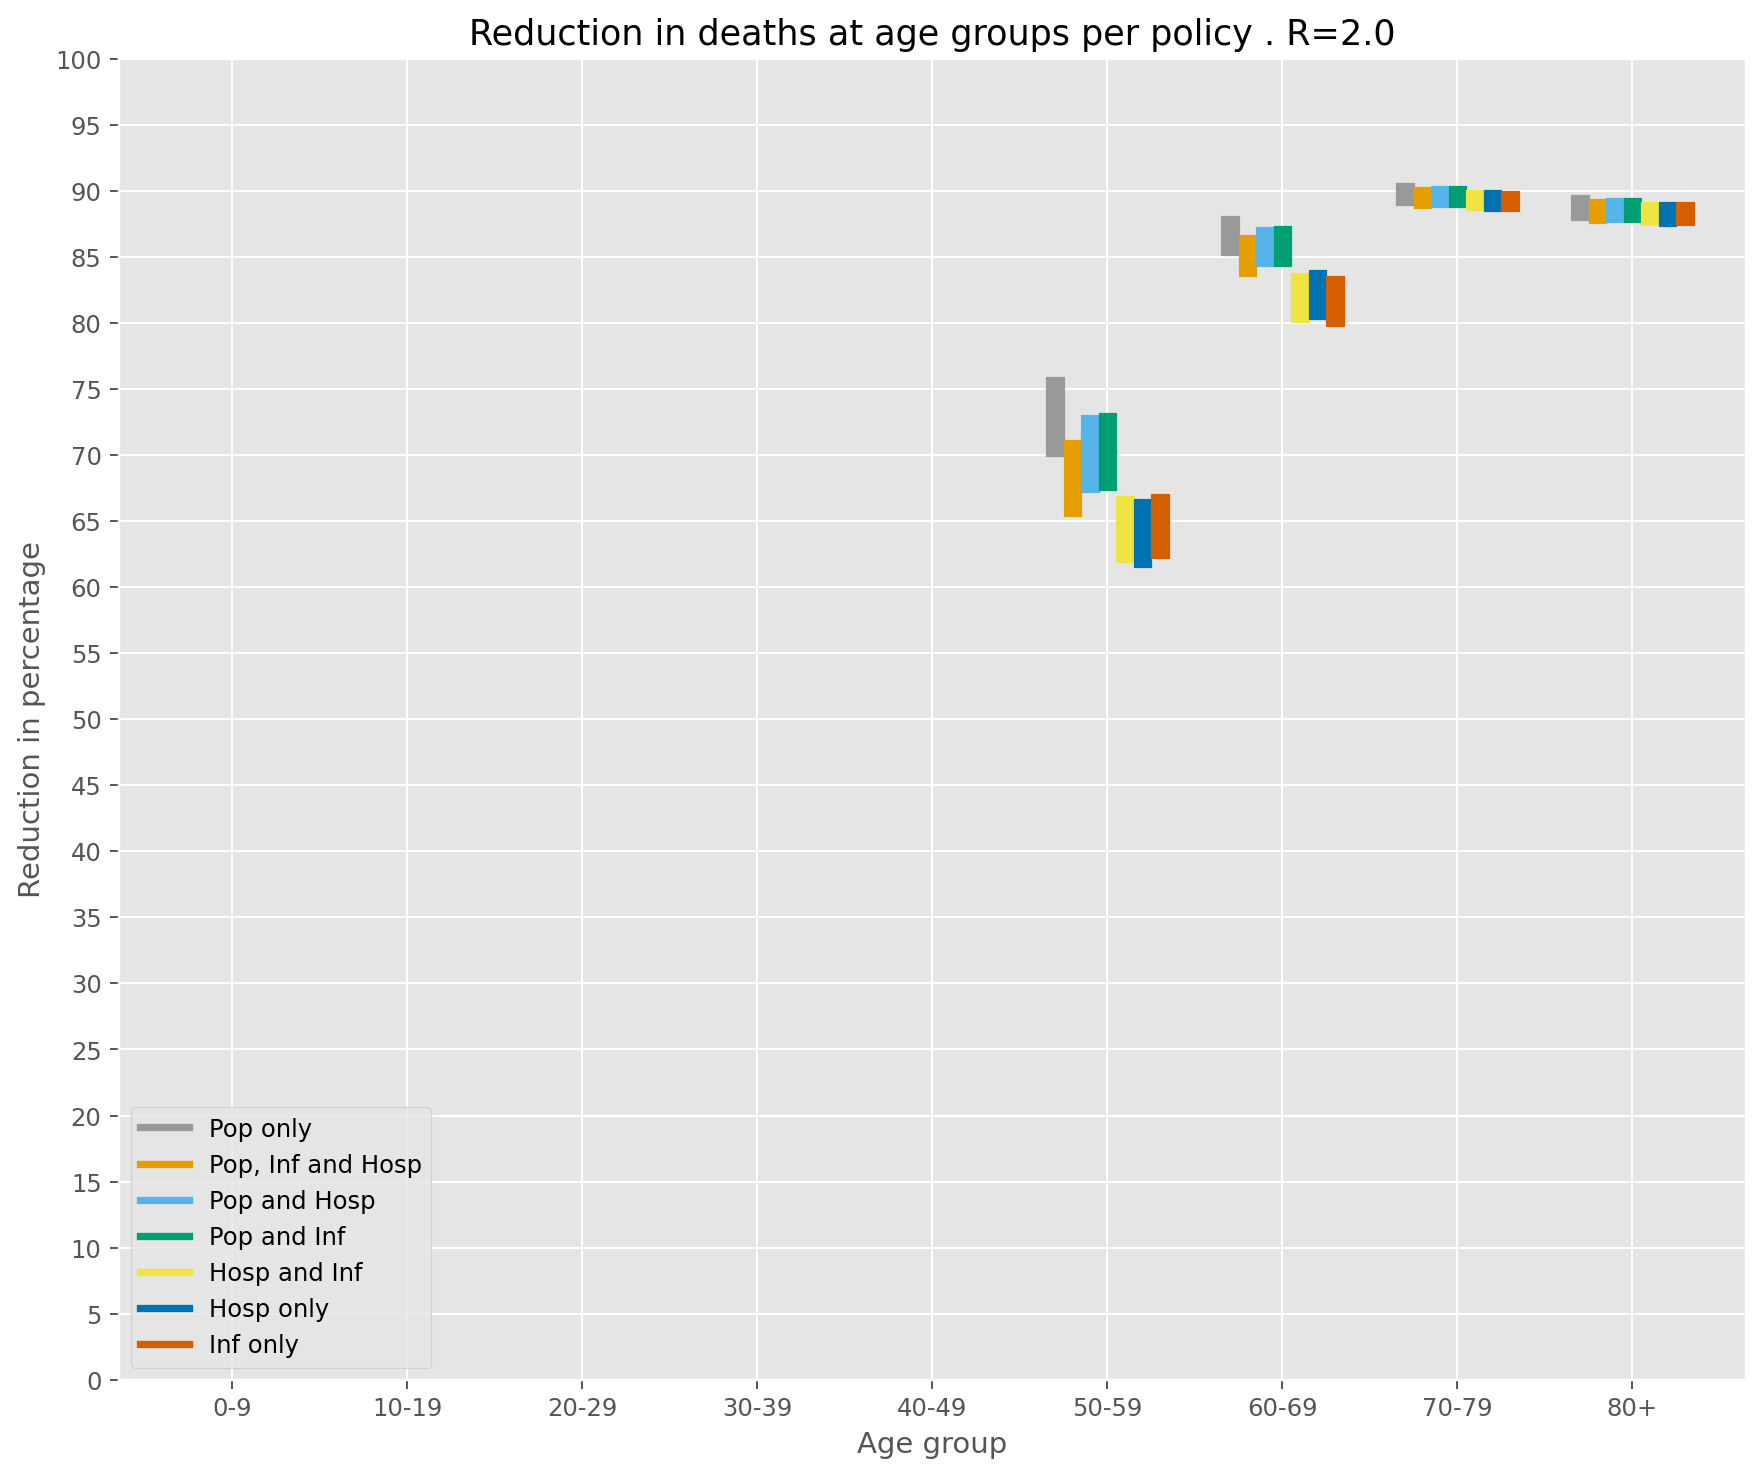

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[3], 'deaths', all_results, age_labels)

# Hospitalizations at age groups

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


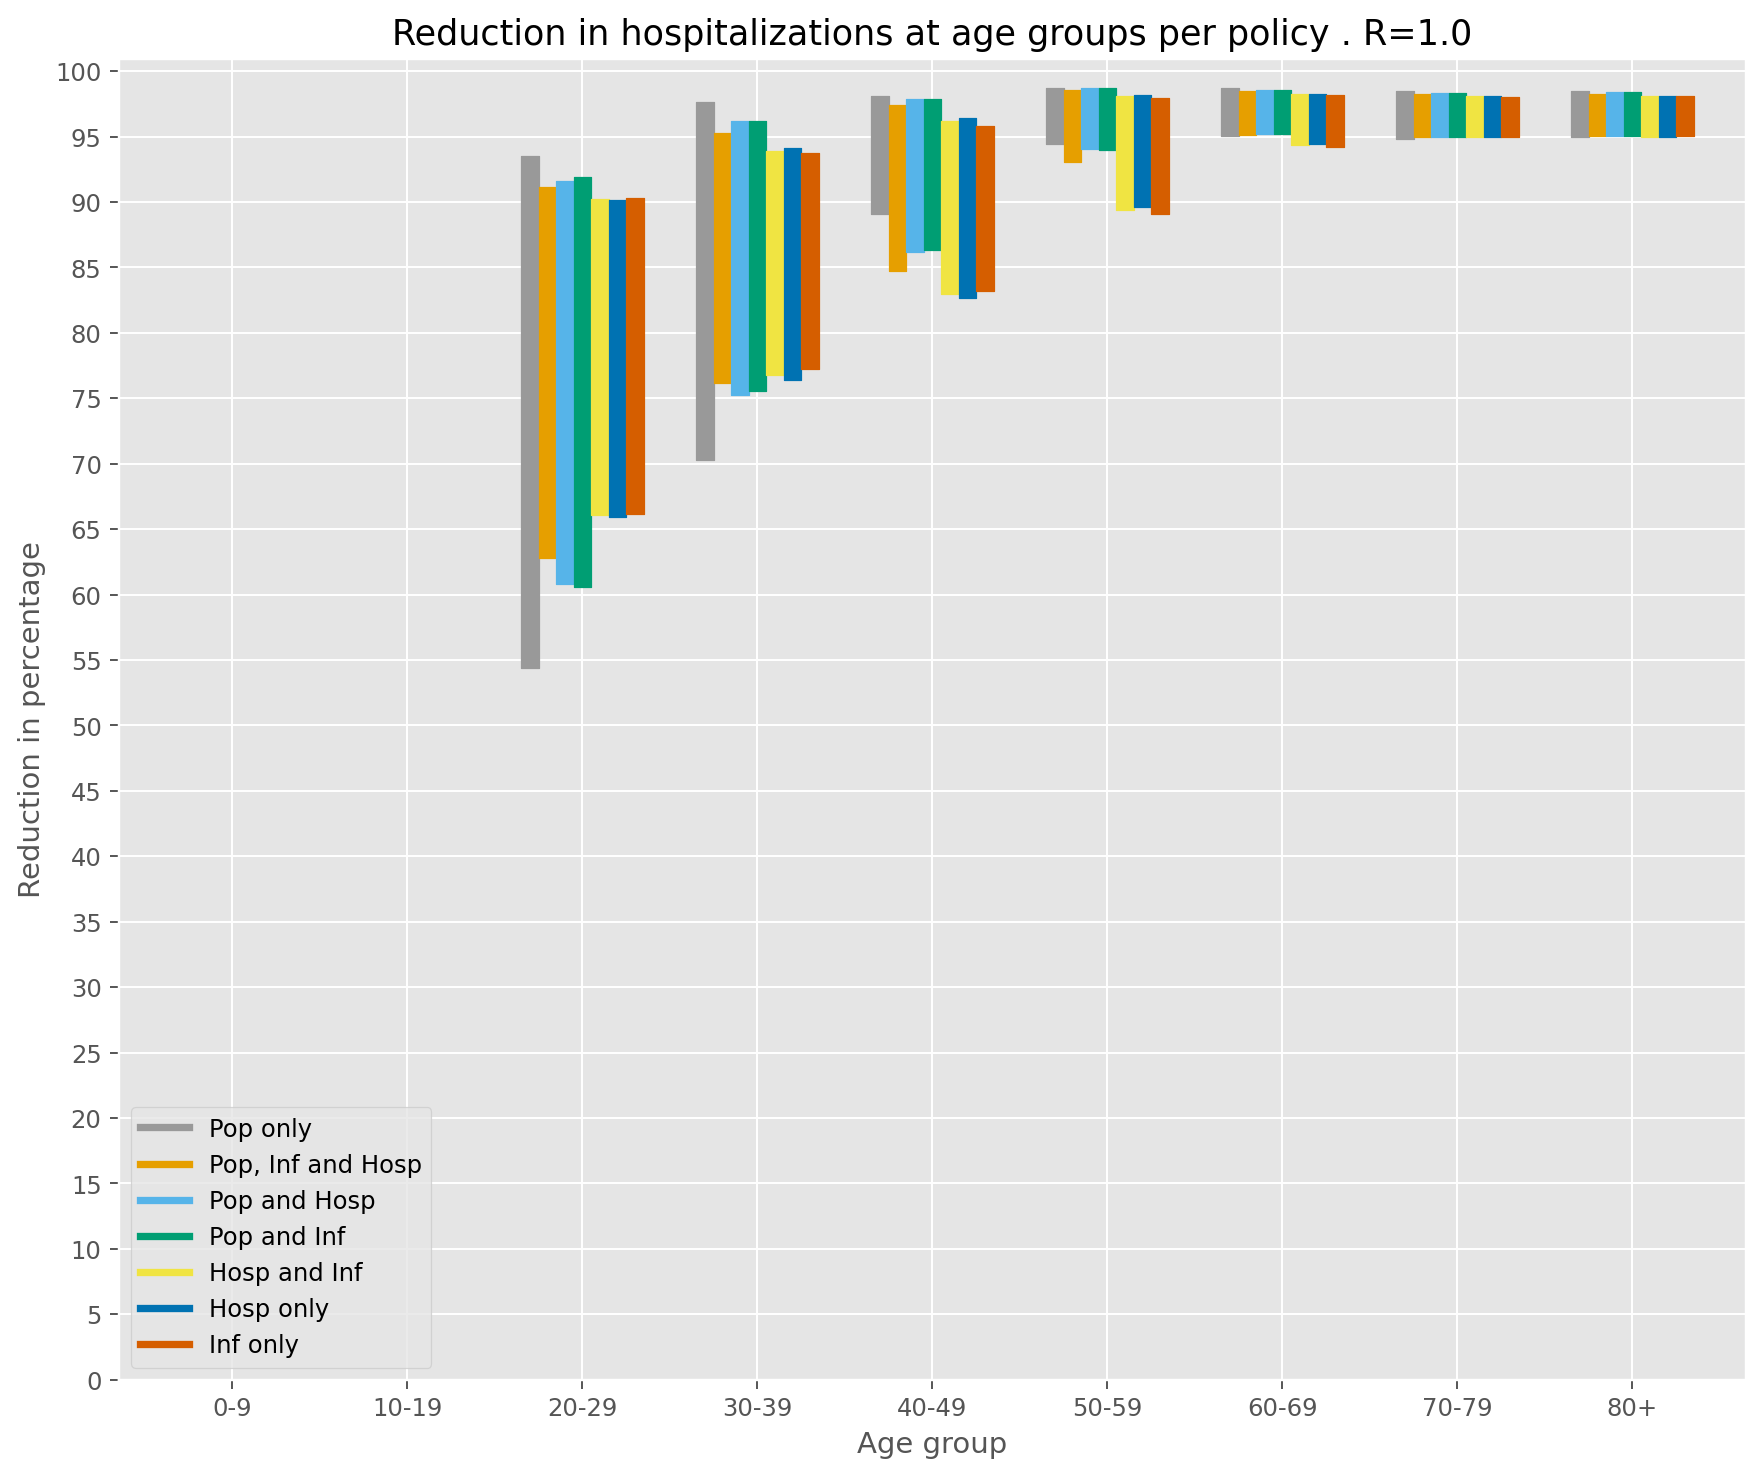

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[0], 'hospitalizations', all_results, age_labels)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


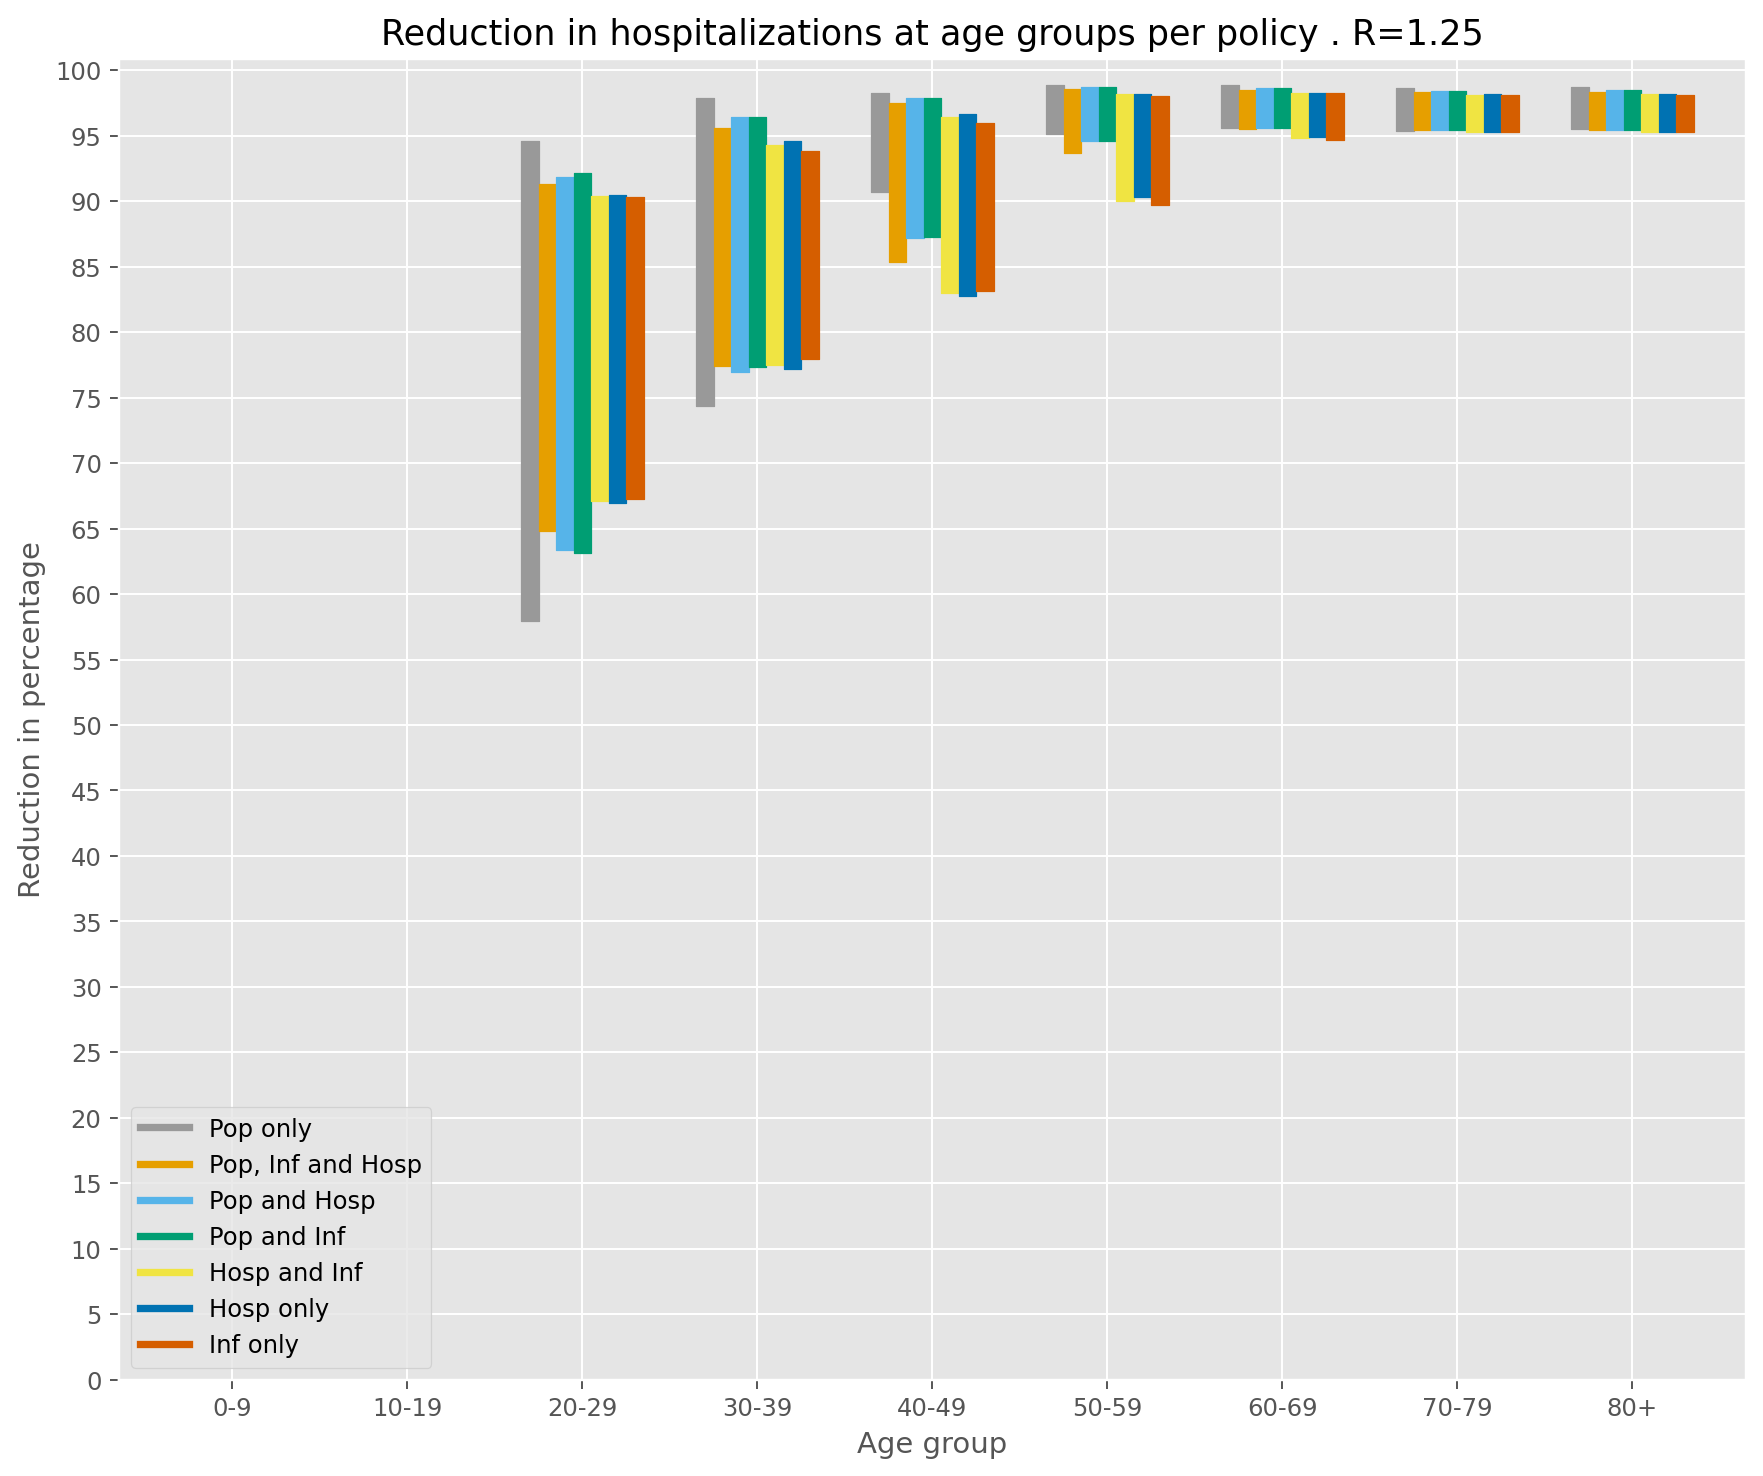

In [23]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[1], 'hospitalizations', all_results, age_labels)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


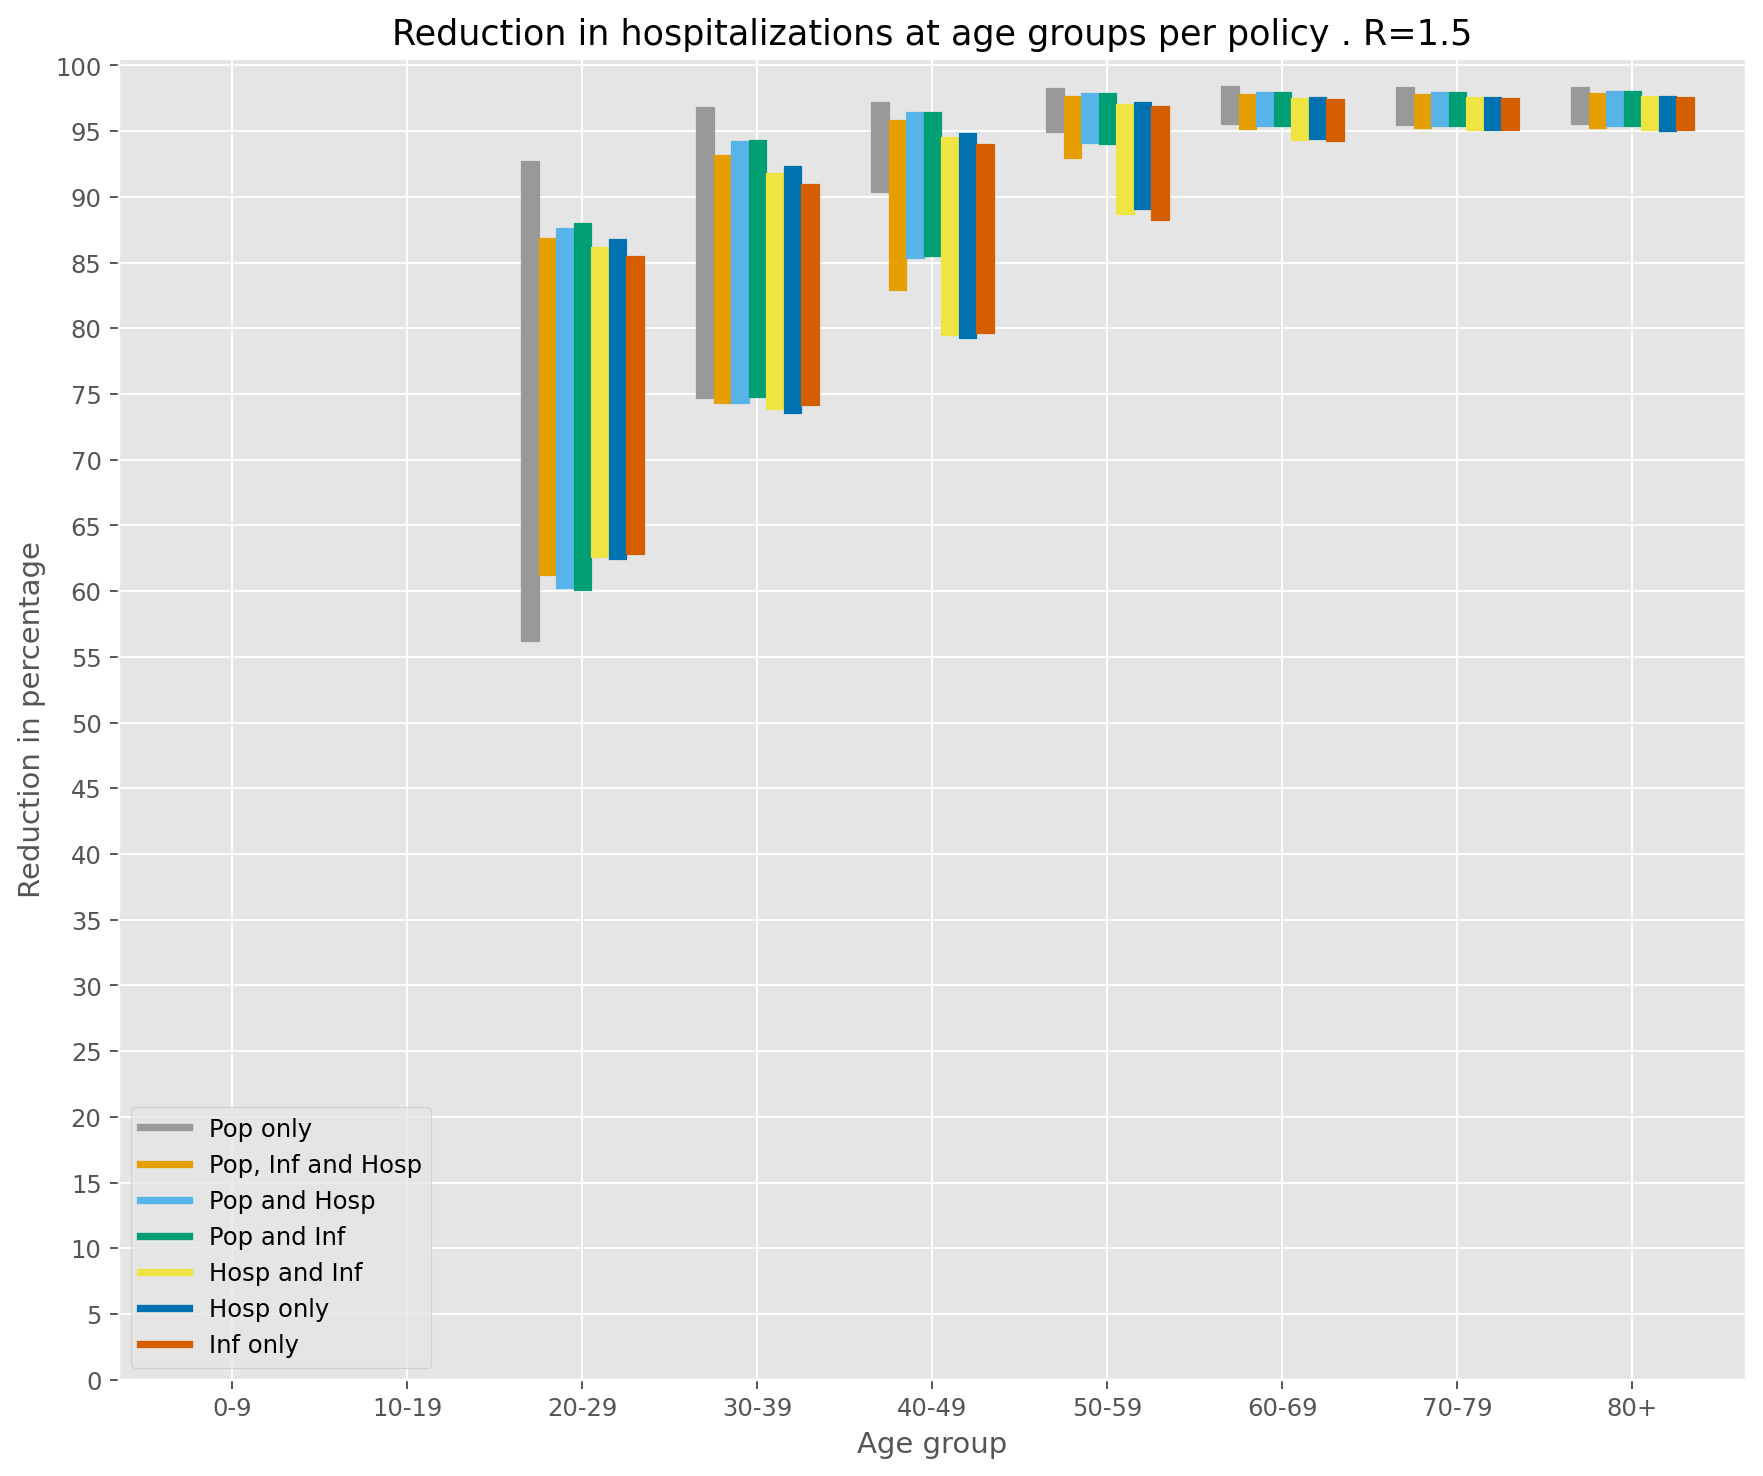

In [24]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[2], 'hospitalizations', all_results, age_labels)

/Users/aponcedeleonch/Documents/Aalto/Courses/MasterThesis/Code/norway-commuter_model-spread/env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


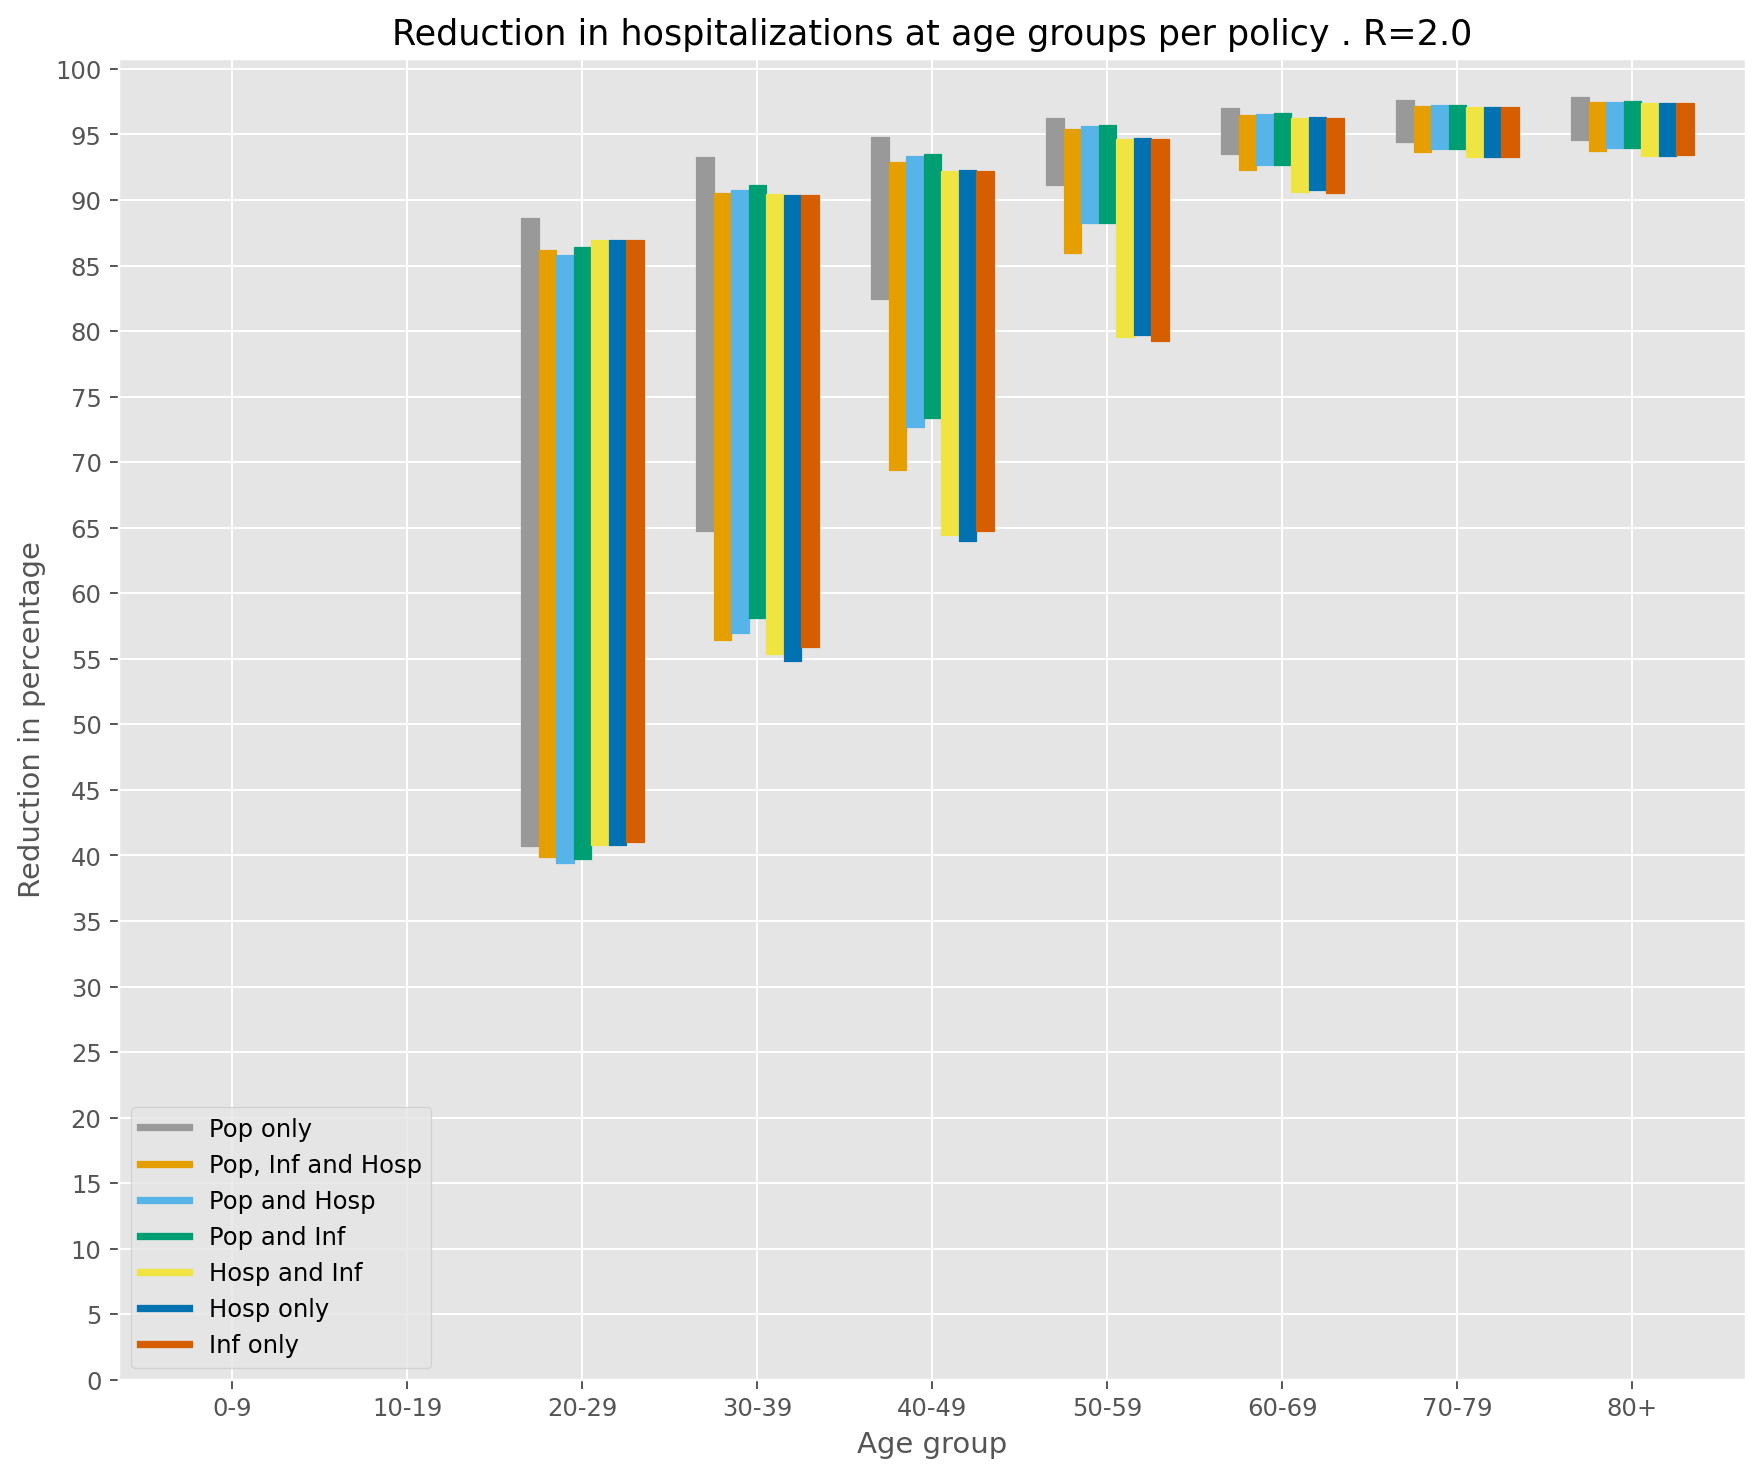

In [25]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[3], 'hospitalizations', all_results, age_labels)

# Infections at age groups

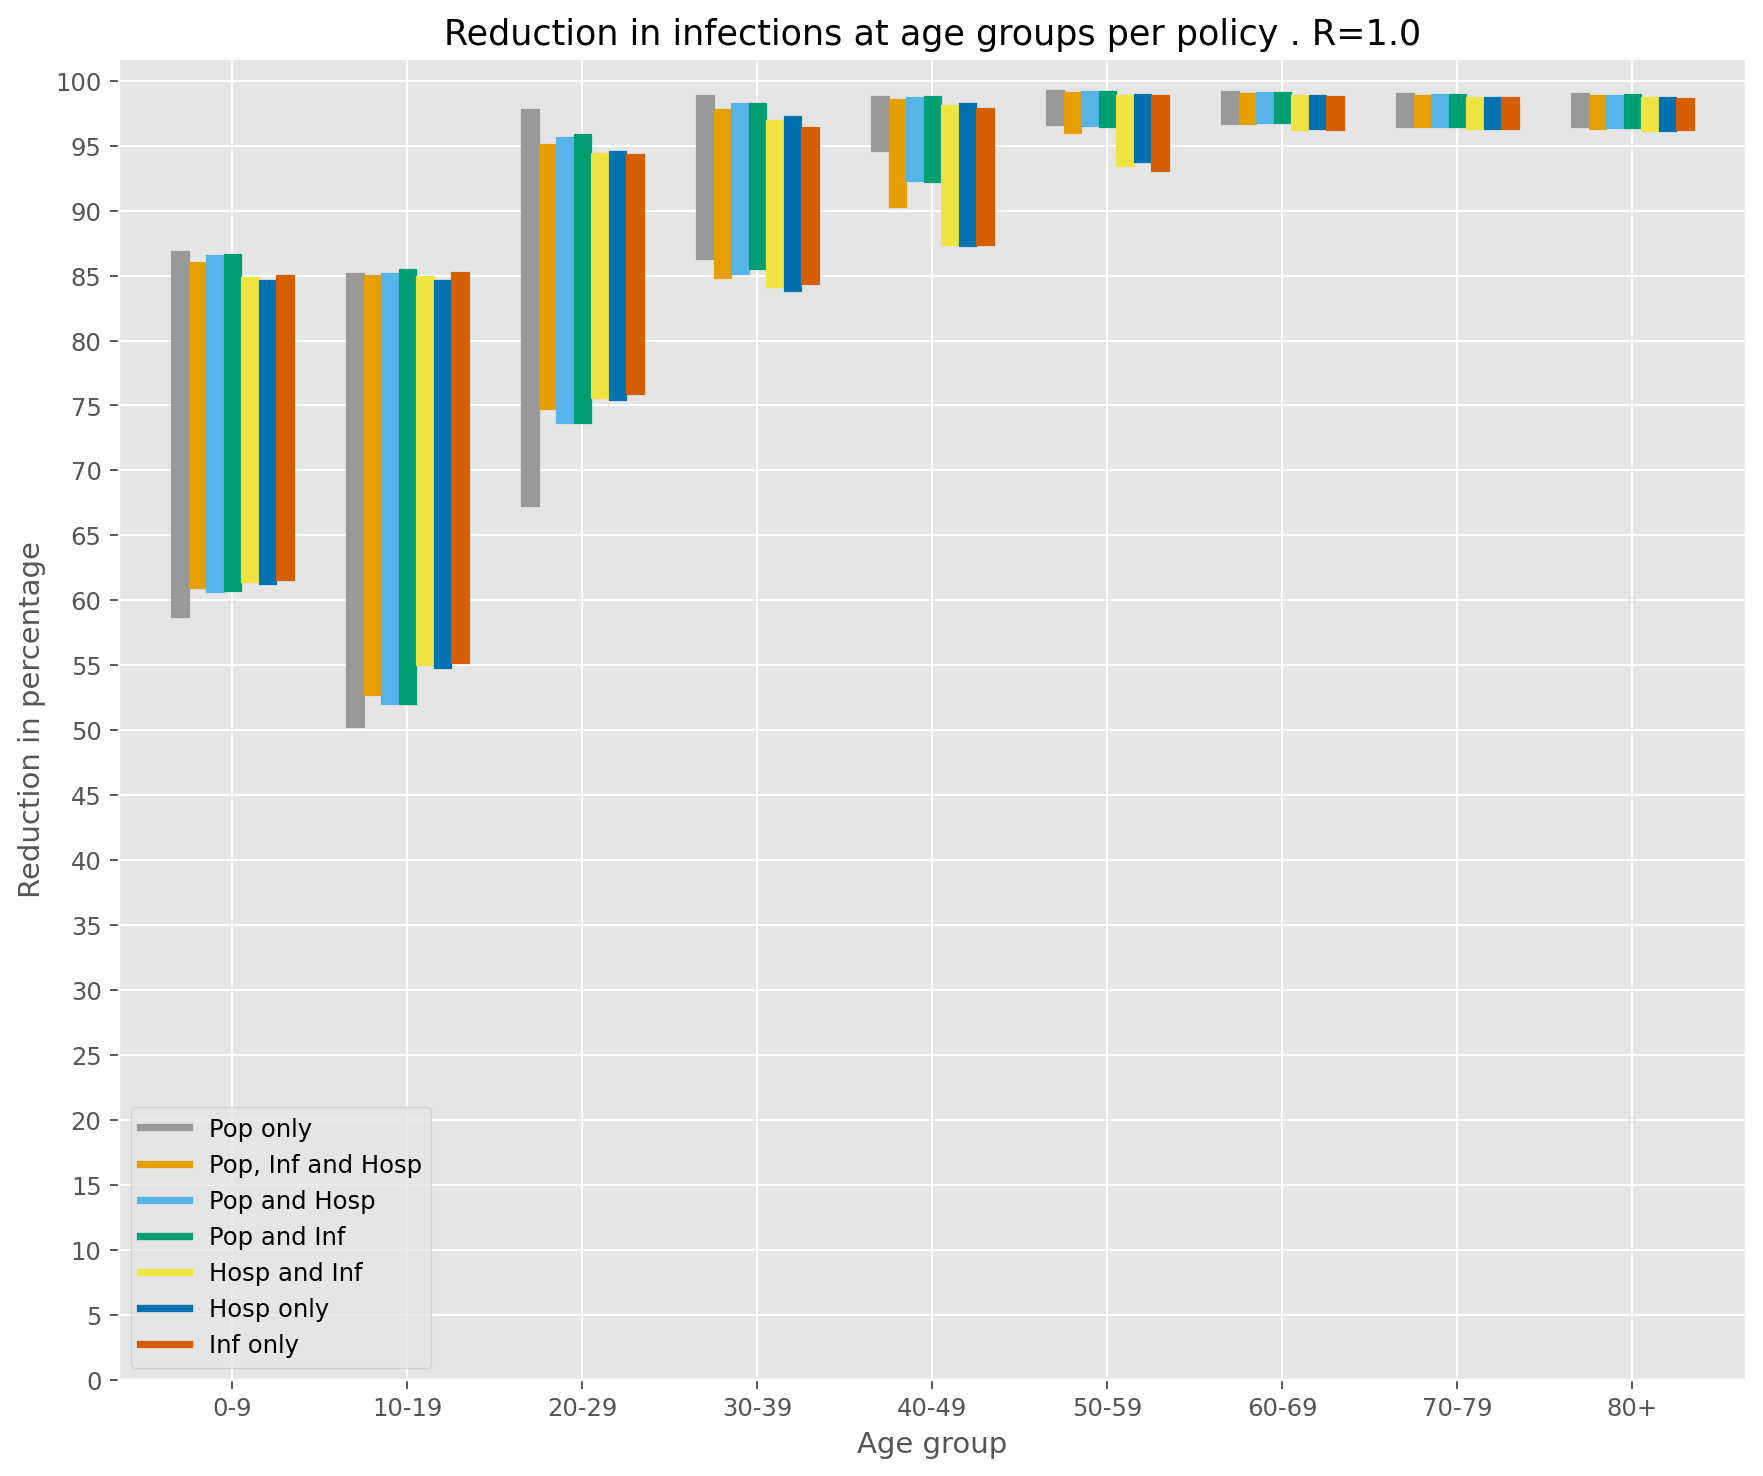

In [26]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[0], 'infections', all_results, age_labels)

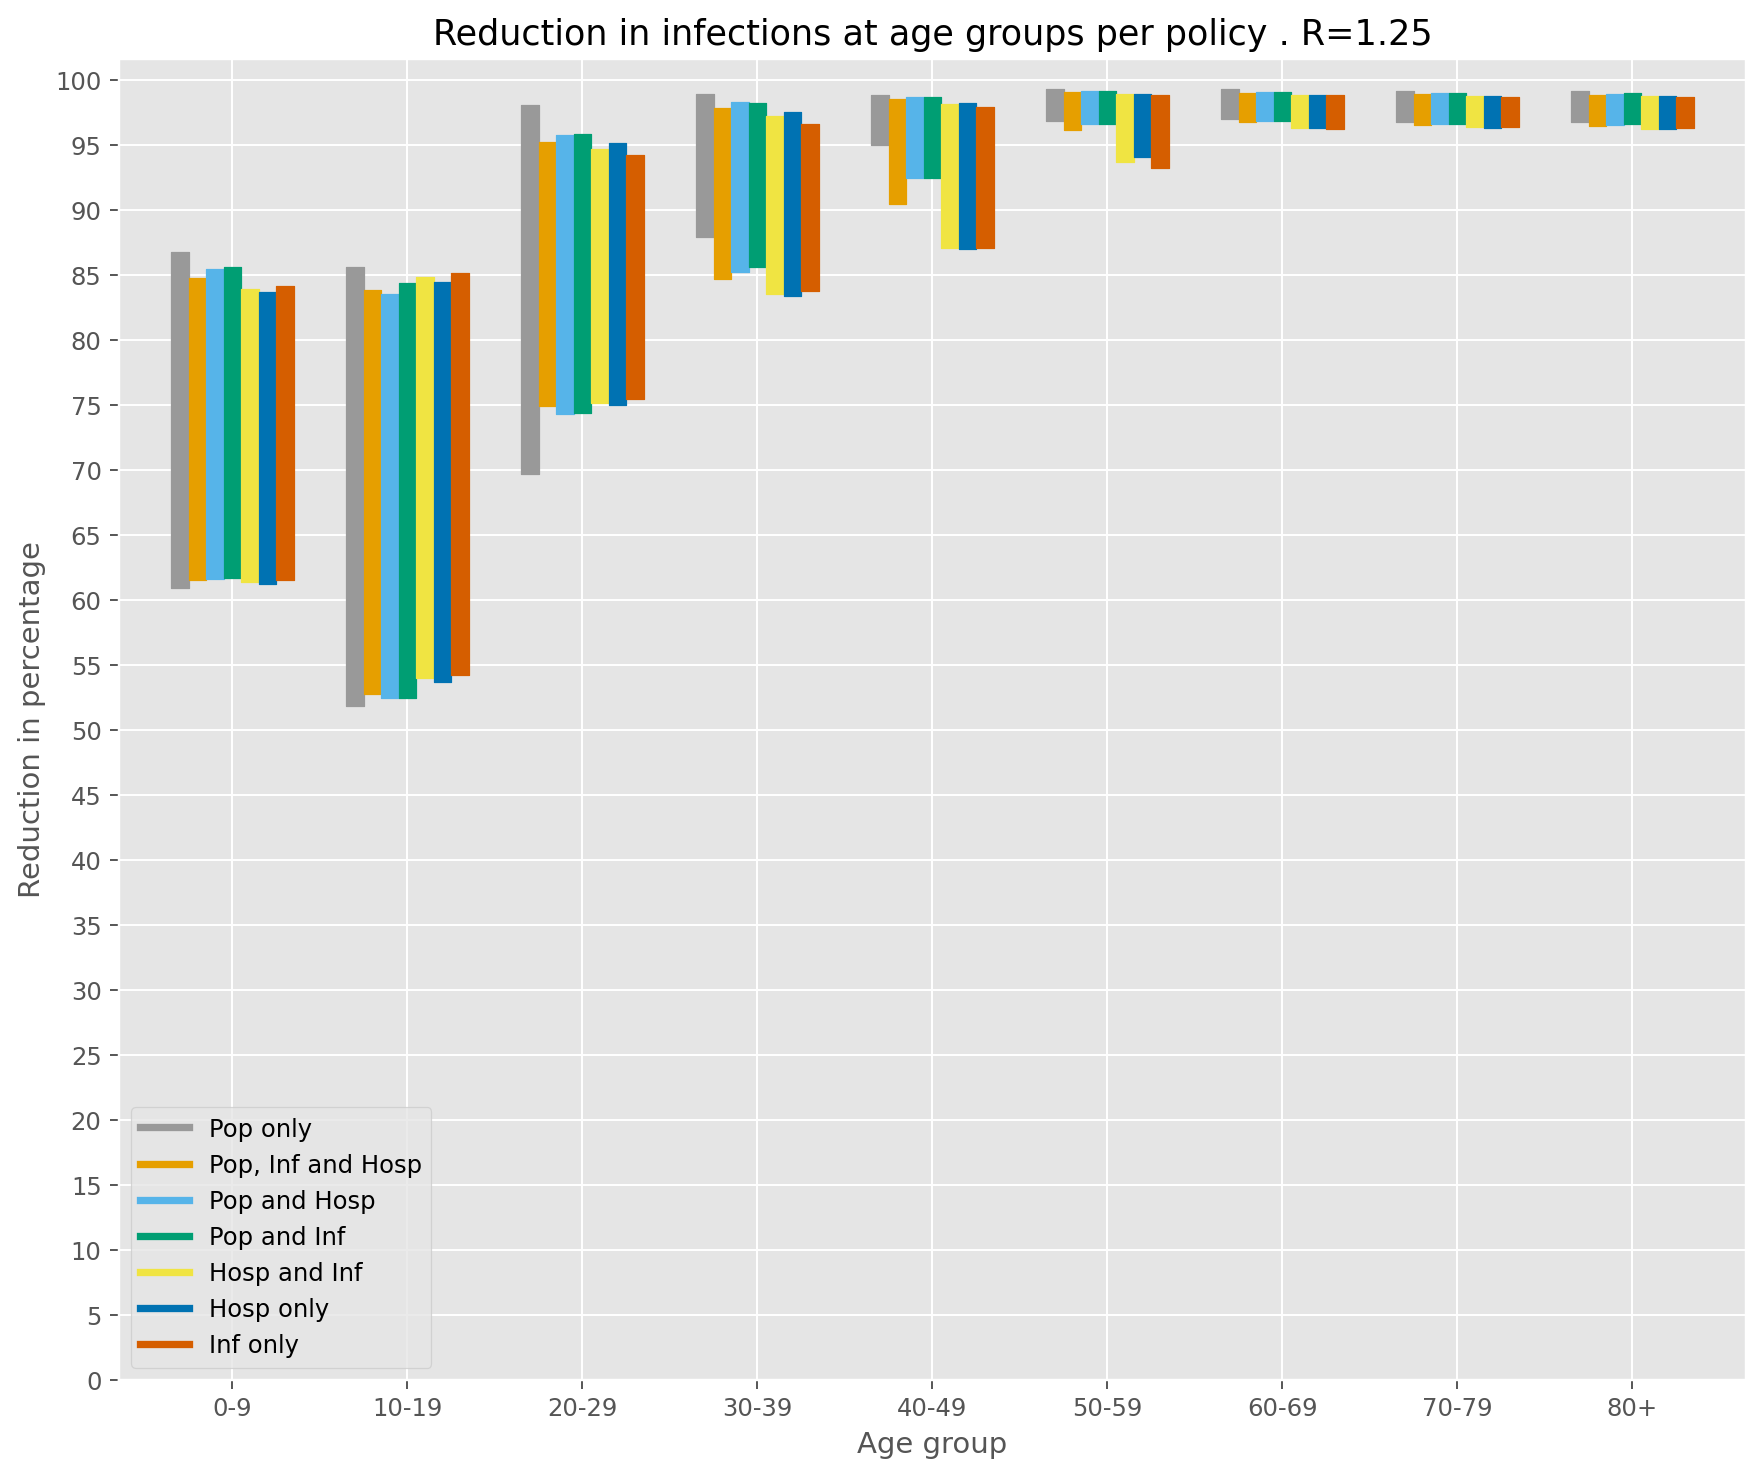

In [27]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[1], 'infections', all_results, age_labels)

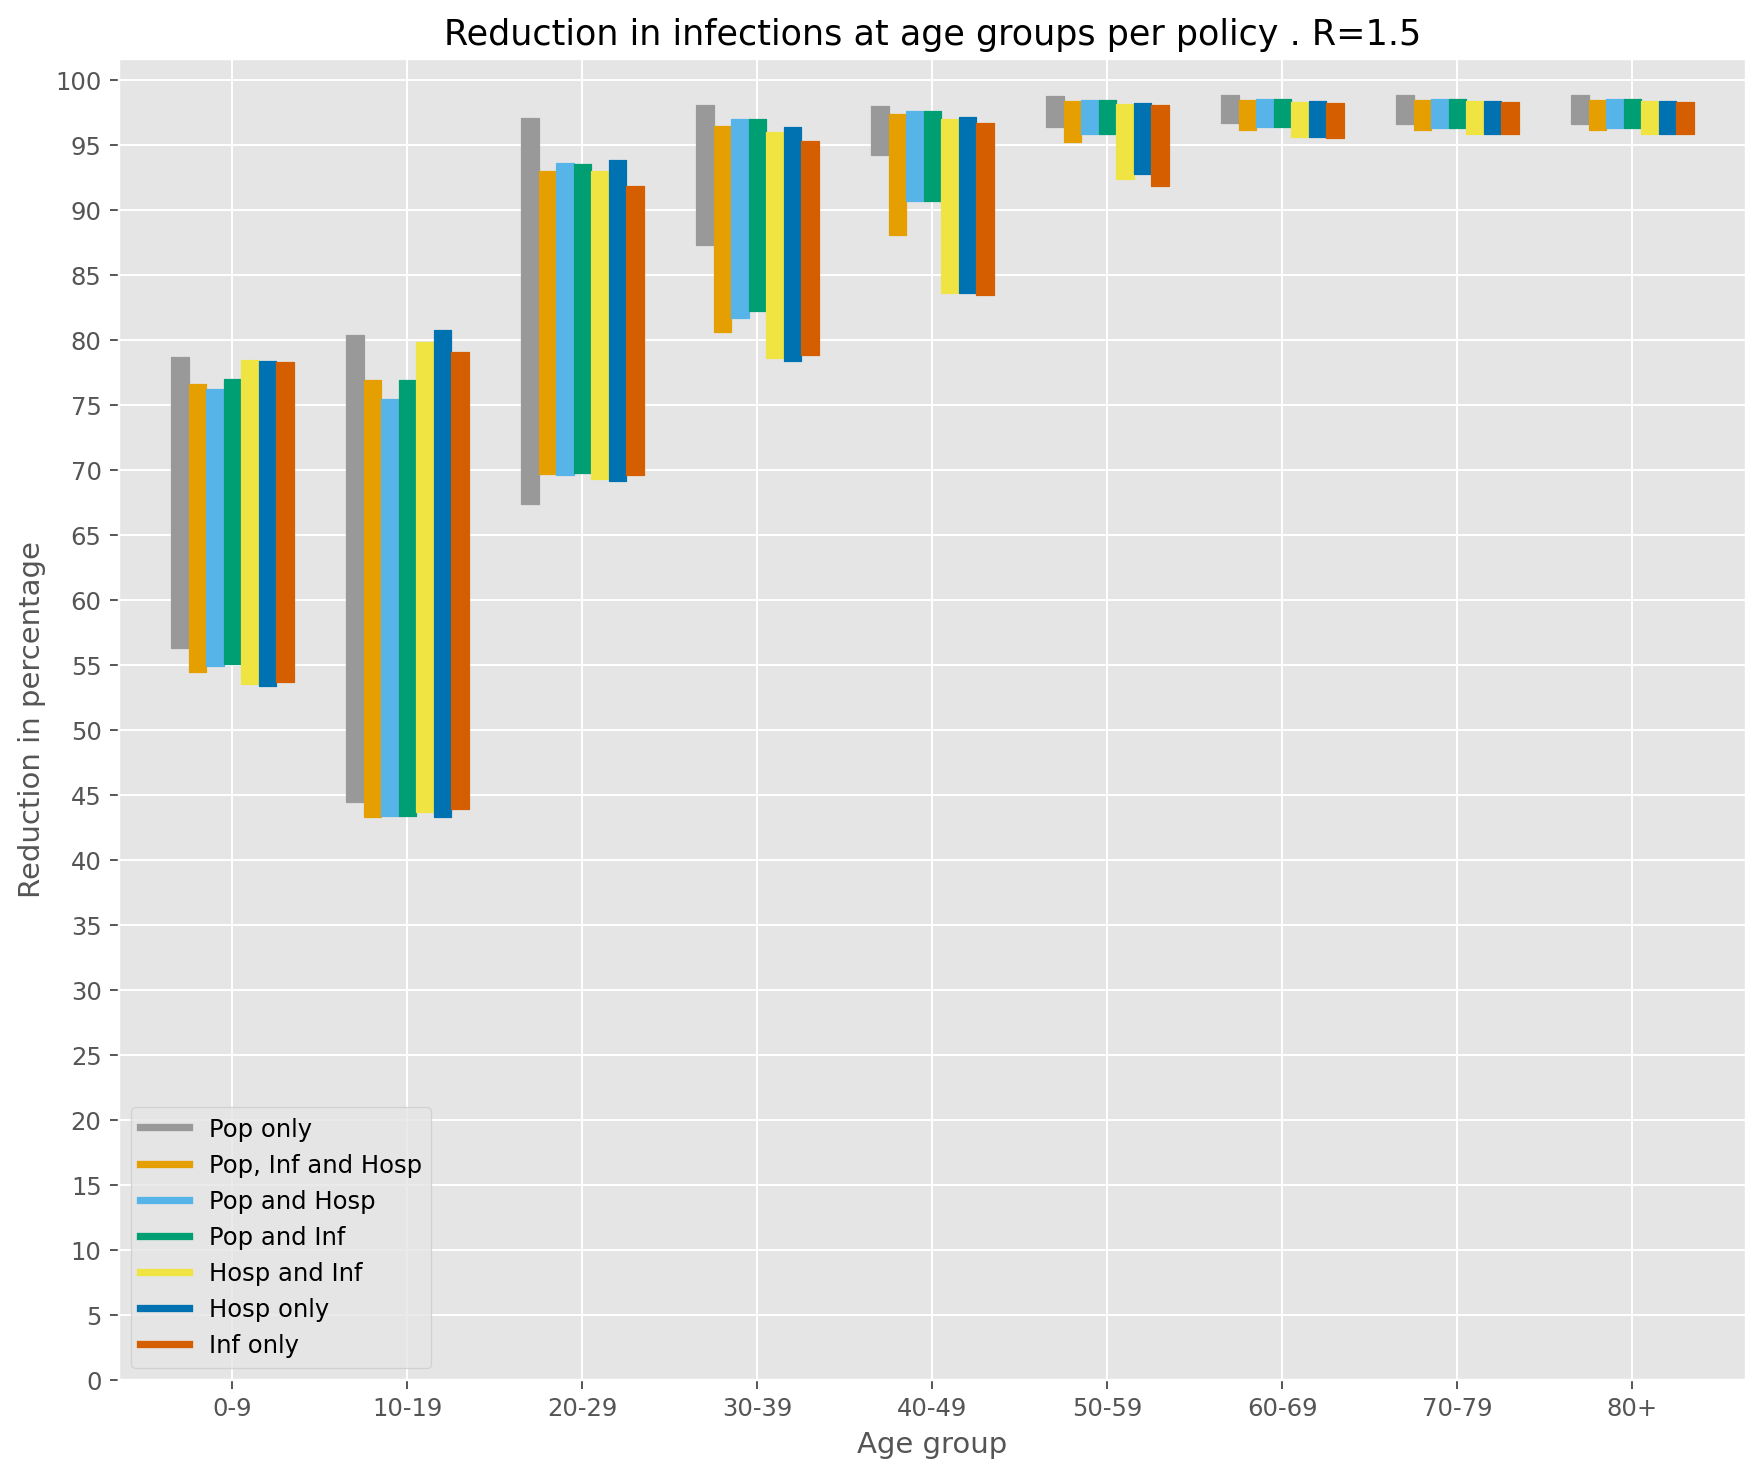

In [28]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[2], 'infections', all_results, age_labels)

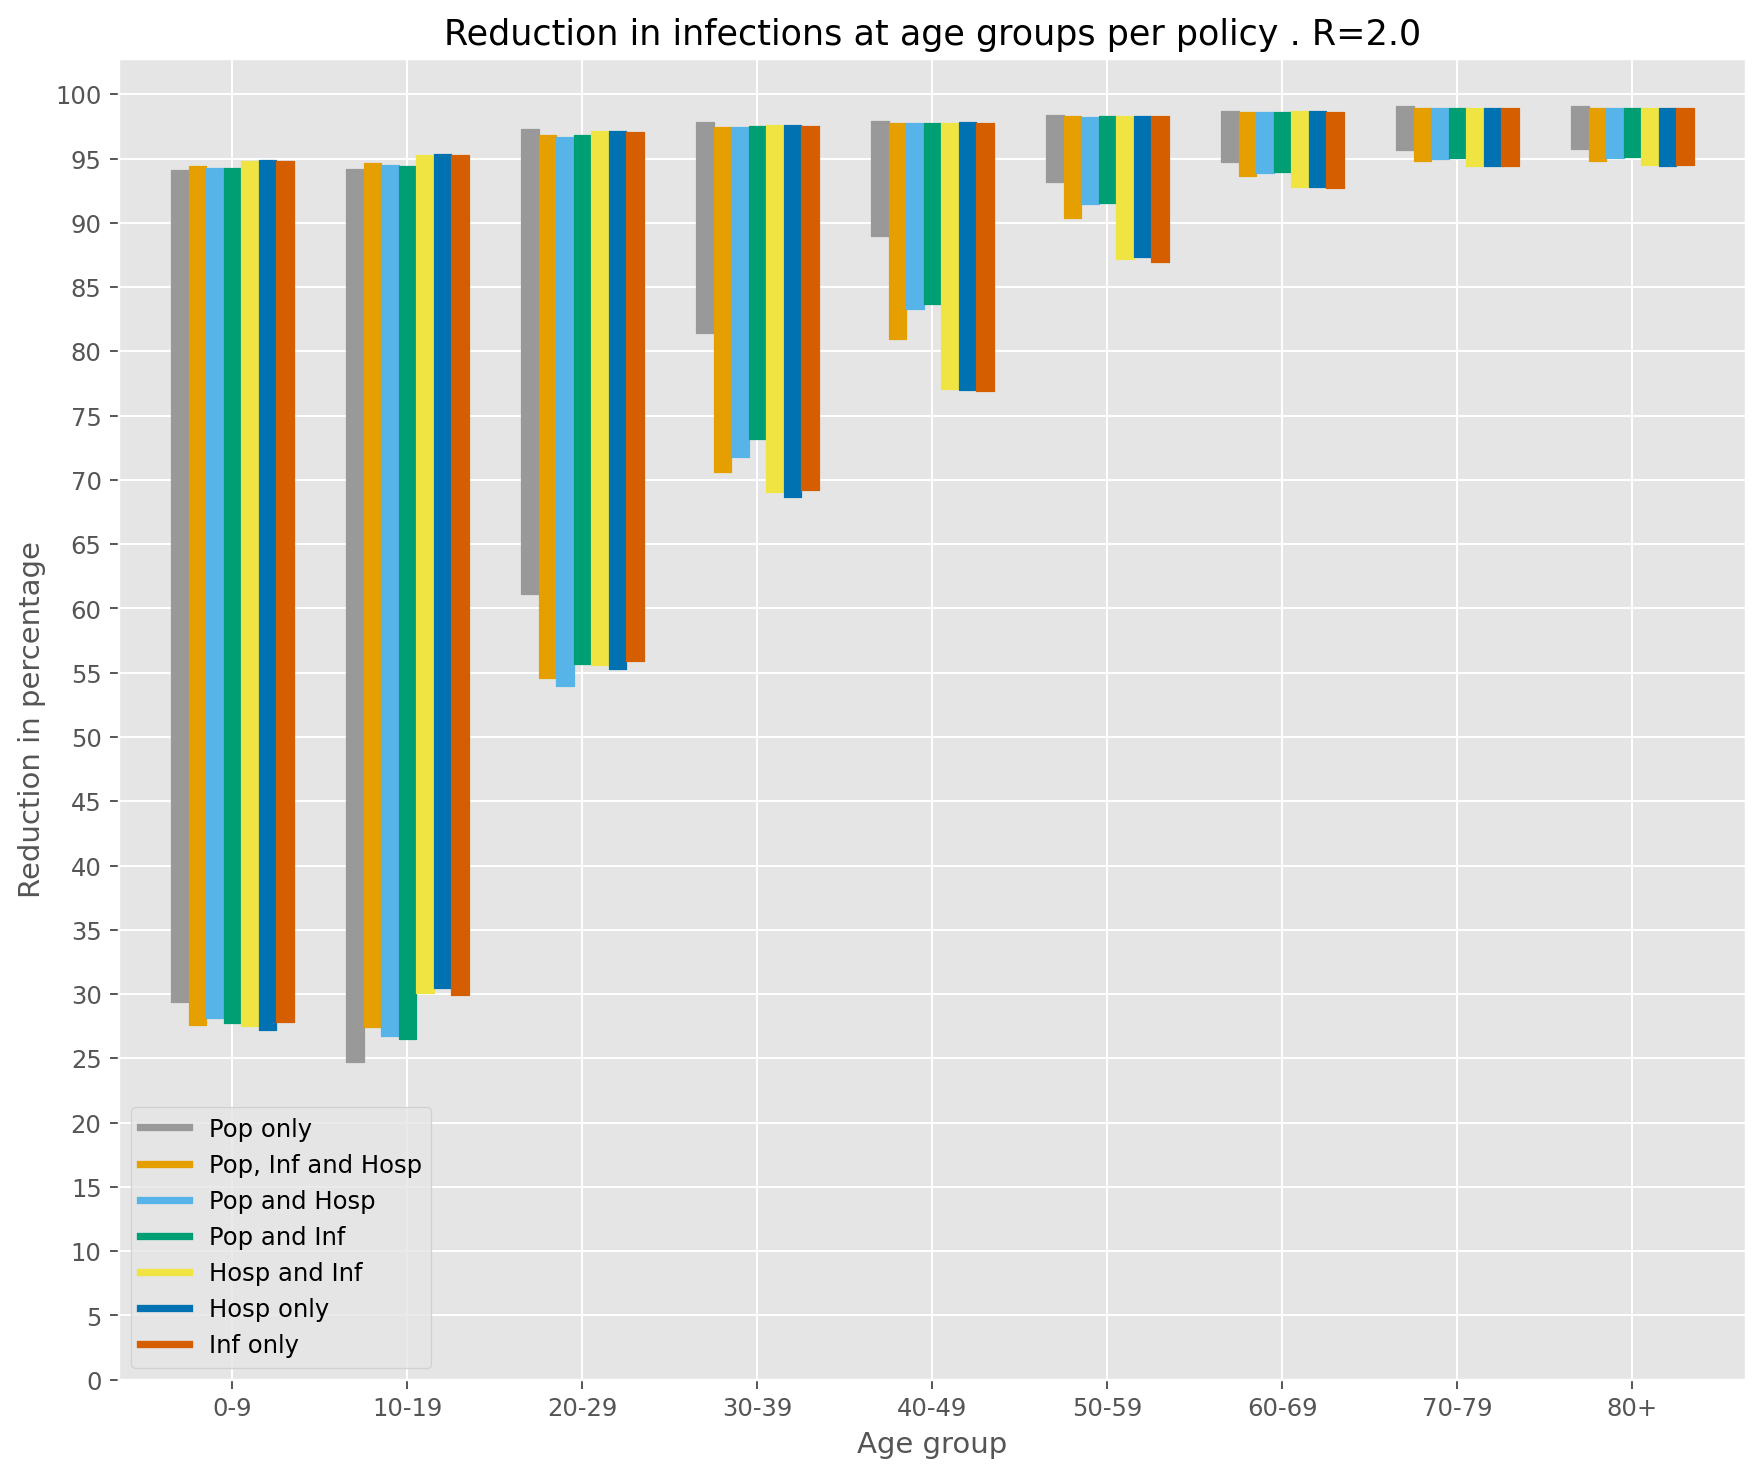

In [29]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = plot_age_groups(ax, r_experiments[3], 'infections', all_results, age_labels)